In [1]:
import numpy as np
from numpy import trapz
import pandas as pd
import random
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import curve_fit as curve_fit
from scipy.stats import norm,binned_statistic
import scipy.integrate as integrate
from scipy.stats import norm
from astropy.io import ascii, fits
from astropy import wcs
from pymoc.util.catalog import catalog_to_moc
from scipy.stats import norm,kstest

from astropy.stats import bootstrap
from astropy.table import Table,vstack,Column,join
from astropy.cosmology import WMAP9 as cosmo
import astropy.units as u
from astropy.coordinates import SkyCoord,match_coordinates_sky

#import emcee
import time
#import corner
import herschelhelp
from matplotlib.colors import LogNorm
from lifelines import KaplanMeierFitter
from herschelhelp import image_plotting
from herschelhelp_internal.utils import inMoc,flux_to_mag
import pymoc
from pymoc.io.fits import read_moc_fits

from astropy.io import registry
from astropy.table.info import serialize_method_as
import statsmodels.duration.survfunc as survfunc

In [2]:
def linear_fit(x,m,c):
    y = m*x + c
    return(y)

In [3]:
def calistro_fit(z):
    law = 1.72*(1+z)**(-0.22)
    return(law)

In [4]:
def delhaize_fit(z):
    law = 2.88*(1+z)**(-0.19) + np.log10((1400/150)**(-0.78))
    return(law)

In [5]:
delhaize_fit(np.array([0,0.5,1]))

array([2.12337131, 1.90983178, 1.76799579])

In [6]:
def get_center(bins):
    centers = (bins[:-1] + bins[1:])/2
    return(centers)

In [7]:
def power_law(x,N,a):
    y = N * (1+x)**a
    return(y)

In [8]:
def create_sf_mask(NUV,r,j):
    #creates a mask to select SF galaxies based on the criteria from Davidzon et al 2017
    NUV_r = NUV - r
    r_j = r-j
    mask = (NUV_r>3.1) & ((NUV_r - 3*r_j) > 1)
    return(~mask)

In [9]:
def create_ssfr_mask(z,ssfr):
    #create a mask to select SF galaxies based on their distance to the main sequence
    #any galaxy less that 0.3 dex below the main sequnce is counted as a SF galaxy
    # main sequnce equation taken from Sargent et al 2012
    x = np.arange(0,1,0.0001)
    main_sequnce = power_law(x,1,-2.8) - np.log10(5E10) - 0.3
    ssfr_limit = np.interp(z,x,main_sequnce)
    mask = ssfr>=ssfr_limit
    
    return(mask)

In [10]:
lofar_sed_en1 = Table.read('data/lofar_sed_en1.fits')
print(len(lofar_sed_en1))
lofar_sed_en1[0]

31602


Source_Name,RA,DEC,E_RA,E_DEC,Total_flux,E_Total_flux,Peak_flux,E_Peak_flux,S_Code,Maj,Min,PA,E_Maj,E_Min,E_PA,DC_Maj,DC_Min,DC_PA,Isl_rms,FLAG_WORKFLOW,Prefilter,NoID,lr_fin,optRA,optDec,LGZ_Size,LGZ_Width,LGZ_PA,Assoc,Assoc_Qual,Art_prob,Blend_prob,Hostbroken_prob,Imagemissing_prob,Zoom_prob,Created,Position_from,Renamed_from,FLAG_OVERLAP_RADIO,flag_clean_radio,ID,X_IMAGE,Y_IMAGE,ALPHA_J2000,DELTA_J2000,flag_clean,ID_OPTICAL,ID_SPITZER,FLAG_OVERLAP,u_flux_corr,u_fluxerr_corr,u_mag_corr,u_magerr_corr,g_flux_corr,g_fluxerr_corr,g_mag_corr,g_magerr_corr,r_flux_corr,r_fluxerr_corr,r_mag_corr,r_magerr_corr,i_flux_corr,i_fluxerr_corr,i_mag_corr,i_magerr_corr,z_flux_corr,z_fluxerr_corr,z_mag_corr,z_magerr_corr,y_flux_corr,y_fluxerr_corr,y_mag_corr,y_magerr_corr,g_hsc_flux_corr,g_hsc_fluxerr_corr,g_hsc_mag_corr,g_hsc_magerr_corr,r_hsc_flux_corr,r_hsc_fluxerr_corr,r_hsc_mag_corr,r_hsc_magerr_corr,i_hsc_flux_corr,i_hsc_fluxerr_corr,i_hsc_mag_corr,i_hsc_magerr_corr,z_hsc_flux_corr,z_hsc_fluxerr_corr,z_hsc_mag_corr,z_hsc_magerr_corr,y_hsc_flux_corr,y_hsc_fluxerr_corr,y_hsc_mag_corr,y_hsc_magerr_corr,nb921_hsc_flux_corr,nb921_hsc_fluxerr_corr,nb921_hsc_mag_corr,nb921_hsc_magerr_corr,J_flux_corr,J_fluxerr_corr,J_mag_corr,J_magerr_corr,K_flux_corr,K_fluxerr_corr,K_mag_corr,K_magerr_corr,ch1_swire_flux_corr,ch1_swire_fluxerr_corr,ch1_swire_mag_corr,ch1_swire_magerr_corr,ch2_swire_flux_corr,ch2_swire_fluxerr_corr,ch2_swire_mag_corr,ch2_swire_magerr_corr,ch3_swire_flux_corr,ch3_swire_fluxerr_corr,ch3_swire_mag_corr,ch3_swire_magerr_corr,ch4_swire_flux_corr,ch4_swire_fluxerr_corr,ch4_swire_mag_corr,ch4_swire_magerr_corr,ch1_servs_flux_corr,ch1_servs_fluxerr_corr,ch1_servs_mag_corr,ch1_servs_magerr_corr,ch2_servs_flux_corr,ch2_servs_fluxerr_corr,ch2_servs_mag_corr,ch2_servs_magerr_corr,Separation,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,SFR_bayes,chi2,chi2_99_flag,LIR_8_1000_med,LIR_8_1000_p16,LIR_8_1000_p84,LIR_8_1000_ml,LIR,LIR_em,LIR_ep,logL150,goodAF,ln_l,q150,radio_luminosity,q_magphys,q_agnfitter,q_250,q_350,q_500,kcorr_250,kcorr_350,kcorr_500,Radio_ID,Spitzer_SN,Donley,Lacy,Stern,Messias,KI,Ch2_Ch4,Ch4_24mu,Xray,Opt_spec,AGNfrac_af,AGNfrac_af_16,AGNfrac_cg_s,AGNfrac_cg_s_16,AGNfrac_cg_f,AGNfrac_cg_f_16,Chi_sq_MpBp,Chi_sq_AfCg,AGN_final,Mass_conc,SFR_conc,Radio_excess,Radio_excess_DJS,Extended_radio,RadioAGN_final
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,

In [11]:
lofar_magphys_en1 = Table.read('data/magphys_mass_radio_limits_en1.fits')
#mask = lofar_magphys_en1['q_lim']==1E20
#lofar_magphys_en1['q_lim'][mask] = np.nan
print(len(lofar_magphys_en1))
lofar_magphys_en1[0]

146996


ID,z,chi2,chi2_99_flag,fmu_sfh_best,fmu_sfh_sigma,fmu_sfh_bayes,fmu_sfh_03,fmu_sfh_16,fmu_sfh_50,fmu_sfh_84,fmu_sfh_98,fmu_IR_best,fmu_IR_sigma,fmu_IR_bayes,fmu_IR_3,fmu_IR_16,fmu_IR_50,fmu_IR_86,fmu_IR_98,mu_best,mu_sigma,mu_bayes,mu_03,mu_16,mu_50,mu_84,mu_98,tau_V_best,tau_V_sigma,tau_V_bayes,tau_V_03,tau_V_16,tau_V_50,tau_V_84,tau_V_98,sSFR_best,sSFR_sigma,sSFR_bayes,sSFR_03,sSFR_16,sSFR_50,sSFR_84,sSFR_98,Mstar_best,Mstar_sigma,Mstar_bayes,Mstar_03,Mstar_16,Mstar_50,Mstar_84,Mstar_98,Ldust_best,Ldust_sigma,Ldust_bayes,Ldust_03,Ldust_16,Ldust_50,Ldust_84,Ldust_98,TC_ISM_best,TC_ISM_sigma,TC_ISM_bayes,TC_ISM_03,TC_ISM_16,TC_ISM_50,TC_ISM_84,TC_ISM_98,TW_BC_best,TW_BC_sigma,TW_BC_bayes,TW_BC_03,TW_BC_16,TW_BC_50,TW_BC_84,TW_BC_98,xi_C_tot_best,xi_C_tot_sigma,xi_C_tot_bayes,xi_C_tot_03,xi_C_tot_16,xi_C_tot_50,xi_C_tot_84,xi_C_tot_98,xi_PAH_tot_best,xi_PAH_tot_sigma,xi_PAH_tot_bayes,xi_PAH_tot_03,xi_PAH_tot_16,xi_PAH_tot_50,xi_PAH_tot_84,xi_PAH_tot_98,xi_MIR_tot_best,xi_MIR_tot_sigma,xi_MIR_tot_bayes,xi_MIR_tot_03,xi_MIR_tot_16,xi_MIR_tot_50,xi_MIR_tot_84,xi_MIR_tot_98,xi_W_tot_best,xi_W_tot_sigma,xi_W_tot_bayes,xi_W_tot_03,xi_W_tot_16,xi_W_tot_50,xi_W_tot_84,xi_W_tot_98,tau_V_ISM_best,tau_V_ISM_sigma,tau_V_ISM_bayes,tau_V_ISM_03,tau_V_ISM_16,tau_V_ISM_50,tau_V_ISM_84,tau_V_ISM_98,Mdust_best,Mdust_sigma,Mdust_bayes,Mdust_03,Mdust_16,Mdust_50,Mdust_84,Mdust_98,SFR_best,SFR_sigma,SFR_bayes,SFR_03,SFR_16,SFR_50,SFR_84,SFR_98,ID_OPTICAL,ID_SPITZER,RA,DEC,help_id,RA_HELP,DEC_HELP,EBV,CLASS_STAR,FLAG_OVERLAP,FLAG_CLEAN,u_flux,u_fluxerr,g_flux,g_fluxerr,r_flux,r_fluxerr,i_flux,i_fluxerr,z_flux,z_fluxerr,y_flux,y_fluxerr,g_hsc_flux,g_hsc_fluxerr,r_hsc_flux,r_hsc_fluxerr,i_hsc_flux,i_hsc_fluxerr,z_hsc_flux,z_hsc_fluxerr,y_hsc_flux,y_hsc_fluxerr,nb921_hsc_flux,nb921_hsc_fluxerr,J_flux,J_fluxerr,K_flux,K_fluxerr,ch1_servs_flux,ch1_servs_fluxerr,ch2_servs_flux,ch2_servs_fluxerr,ch1_swire_flux,ch1_swire_fluxerr,ch2_swire_flux,ch2_swire_fluxerr,ch3_swire_flux,ch3_swire_fluxerr,ch4_swire_flux,ch4_swire_fluxerr,F_MIPS_24,FErr_MIPS_24_u,FErr_MIPS_24_l,Bkg_MIPS_24,Sig_conf_MIPS_24,Rhat_MIPS_24,n_eff_MIPS_24,Pval_res_24,flag_mips_24,F_PACS_100,FErr_PACS_100_u,FErr_PACS_100_l,F_PACS_160,FErr_PACS_160_u,FErr_PACS_160_l,Bkg_PACS_100,Bkg_PACS_160,Sig_conf_PACS_100,Sig_conf_PACS_160,Rhat_PACS_100,Rhat_PACS_160,n_eff_PACS_100,n_eff_PACS_160,Pval_res_100,Pval_res_160,flag_PACS_100,flag_PACS_160,F_SPIRE_250,FErr_SPIRE_250_u,FErr_SPIRE_250_l,F_SPIRE_350,FErr_SPIRE_350_u,FErr_SPIRE_350_l,F_SPIRE_500,FErr_SPIRE_500_u,FErr_SPIRE_500_l,Bkg_SPIRE_250,Bkg_SPIRE_350,Bkg_SPIRE_500,Sig_conf_SPIRE_250,Sig_conf_SPIRE_350,Sig_conf_SPIRE_500,Rhat_SPIRE_250,Rhat_SPIRE_350,Rhat_SPIRE_500,n_eff_SPIRE_250,n_eff_SPIRE_500,n_eff_SPIRE_350,Pval_res_250,Pval_res_350,Pval_res_500,flag_spire_250,flag_spire_350,flag_spire_500,Z_BEST,Z_BEST_SOURCE,Z_SPEC,z1_median,z1_min,z1_max,z1_area,z2_median,z2_min,z2_max,z2_area,nfilt_eazy,nfilt_atlas,nfilt_ananna,chi_r_best,chi_r_stellar,stellar_type,AGN,optAGN,IRAGN,XrayAGN,hp_idx_11,hp_depth_cluster,tot_corr_g,tot_corr_err_g,tot_corr_r,tot_corr_err_r,tot_corr_z,tot_corr_err_z,zmodel,chi_best,Mass_median,Mass_l68,Mass_u68,SFR_median,SFR_l68,SFR_u68,Nfilts,u_rest,g_rest,r_rest,i_rest,z_rest,y_rest,J_rest,K_rest,ch1_servs_rest,ch2_servs_rest,ch1_swire_rest,ch2_swire_rest,ch3_swire_rest,ch4_swire_rest,radio_flux_pixel,radio_flux_limit,radio_luminosity_pixel,radio_luminosity_limit,q_pixel,q_lim,q_250_lim,q_350_lim,q_500_lim,kcorr_250,kcorr_350,kcorr_500
,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,deg,,deg,deg,,,,,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,uJy,,,,,,,,,,mJy,mJy,mJy,mJy,mJy,mJy,mJy/Beam,mJy/Beam,mJy/Beam,mJy/Beam,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,deg,,,,,,,,,,solMass,solMass,solMass,solMass / yr,solMass 

In [12]:
num = (lofar_magphys_en1['Mstar_bayes']>10.0**(10.2)) & (lofar_magphys_en1['z']<0.4)
print(np.sum(num))

30663


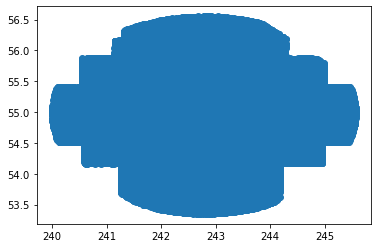

In [19]:
x = lofar_magphys_en1['RA']
y = lofar_magphys_en1['DEC']
plt.scatter(x,y)
plt.show()

/its/home/im281/.conda/envs/herschelhelp_v2/lib/python3.7/site-packages/ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in log10
  """


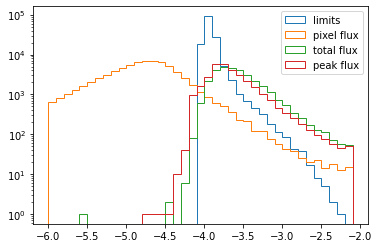

In [20]:
bins= np.arange(-6,-2,0.1)
y = np.log10(lofar_magphys_en1['radio_flux_limit'])
plt.hist(y,bins=bins,log=True,histtype='step',label='limits')

y = np.log10(lofar_magphys_en1['radio_flux_pixel'])
plt.hist(y,bins=bins,log=True,histtype='step',label='pixel flux')

y = np.log10(lofar_sed_en1['Total_flux'])
plt.hist(y,bins=bins,log=True,histtype='step',label='total flux')

y = np.log10(lofar_sed_en1['Peak_flux'])
plt.hist(y,bins=bins,log=True,histtype='step',label='peak flux')

plt.legend()
plt.show()

In [13]:
stellar_mass_cat = Table.read('../../lofar/deep_fields/ELAIS-N1/data/EN1_opt_spitzer_merged_vac_opt3as_irac4as_all_hpx_masses_public.fits')

mask = (stellar_mass_cat['Z_BEST']<1.0) & (stellar_mass_cat['Mass_median']>10.7)
print('there are {} sources with M>10.7 and z<1.0'.format(np.sum(mask)))

there are 29329 sources with M>10.7 and z<1.0


In [14]:
mask = (stellar_mass_cat['Z_BEST']<0.4) & (stellar_mass_cat['Mass_median']>10.0)
print('there are {} sources with M>10.7 and z<1.0'.format(np.sum(mask)))

there are 15583 sources with M>10.7 and z<1.0


In [15]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7
mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (lofar_sed_en1['Mass_median']>10.7)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))>-10.5
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))



mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (lofar_magphys_en1['Mass_median']>10.7)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median'])>-10.5
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

There are 0 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 5240 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


In [16]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

#mask_loc = (lofar_sed_en1['RA']>242.5) & (lofar_sed_en1['RA']<243.5) & (lofar_sed_en1['DEC']>54) & (lofar_sed_en1['DEC']<56) 
mstar = np.log10(lofar_sed_en1['Mstar_bayes']/3.8E26)
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - mstar)>-10.5
#ssfr = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))
#SSFR_mask = create_ssfr_mask(lofar_sed_en1['Z_BEST'],ssfr)
detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_sample_en1)))


mstar = np.log10(lofar_magphys_en1['Mstar_bayes']/3.8E26)
mask_loc = (lofar_magphys_en1['RA']>242.5) & (lofar_magphys_en1['RA']<243.5) & (lofar_magphys_en1['DEC']>54) & (lofar_magphys_en1['DEC']<56)
mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (mstar>10.45)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - mstar)>-10.5
#ssfr = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median'])
#SSFR_mask = create_ssfr_mask(lofar_magphys_en1['Z_BEST'],ssfr)
limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_sample_en1)))

There are 7641 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 17249 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1


measured median from the detections is: 1.6512416620001495
measured median using survival analysis is: 1.9155904781011515


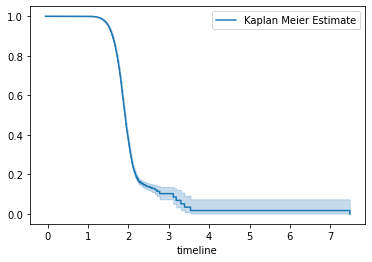

median q = 1.9155904781011515


In [18]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'


detected_data = detected_sample_en1[det_name]
mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name]))
detected_data = detected_data[mask]
redshift_det = detected_sample_en1['Z_BEST'][mask]
ldust_det = detected_sample_en1[ldust_name][mask]

limit_data = limit_sample_en1[lim_name]
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]
redshift_lim = limit_sample_en1['Z_BEST'][mask]
ldust_lim = limit_sample_en1[ldust_name][mask]

data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
print('measured median from the detections is: {}'.format(np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(kmf.median_survival_time_))
kmf.plot()
plt.show()

print('median q = {}'.format(kmf.median_survival_time_))




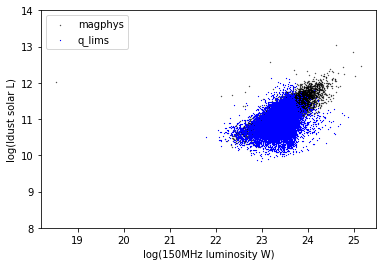

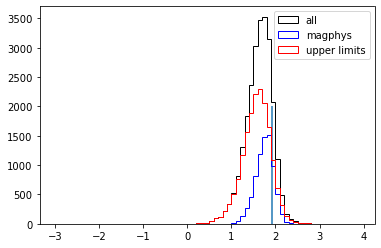

In [19]:
sed_name = 'magphys'
ldust_name = 'Ldust_bayes'
rad_name = 'radio_luminosity'
ldust_lim_name = 'Ldust_bayes'
rad_lim_name = 'radio_luminosity_limit'

x = np.log10(detected_sample_en1[rad_name])
y = np.log10(detected_sample_en1[ldust_name]/3.8E26)
plt.scatter(x,y,s=0.1,label='magphys',c='black')

y = np.log10(limit_sample_en1[ldust_lim_name]/3.8E26)
x = np.log10(limit_sample_en1[rad_lim_name])
plt.scatter(x,y,s=0.1,label='q_lims',c='blue',marker='^')

plt.xlabel('log(150MHz luminosity W)')
plt.ylabel('log(ldust solar L)')
plt.ylim(8.0,14)
plt.legend()
plt.show()

bins = np.arange(-3,4,0.1)

plt.hist(np.append(detected_sample_en1[det_name],limit_sample_en1[lim_name]),label='all',bins=bins,histtype='step',color='black')
plt.hist(detected_sample_en1[det_name],label='magphys',bins=bins,histtype='step',color='blue')
plt.hist(limit_sample_en1[lim_name],label='upper limits',bins=bins,histtype='step',color='red')
plt.vlines(kmf.median_survival_time_,0,2000)
plt.legend()
plt.show()

q = 1.9155895549206203 +/- 0.0030975545058607953
where the error is the standard error of the bootstrapped medians


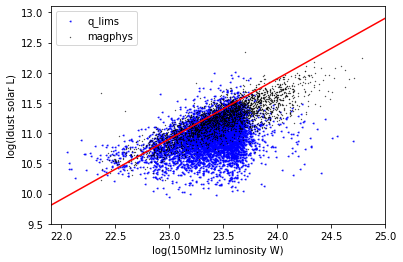

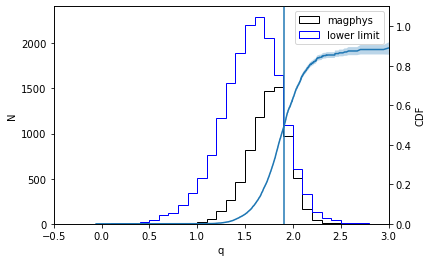

In [25]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

detected_data = detected_sample_en1[det_name][~agn_mask]
mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
detected_data = detected_data[mask]
redshift_det = detected_sample_en1['Z_BEST'][~agn_mask][mask]
ldust_det = detected_sample_en1[ldust_name][~agn_mask][mask]

limit_data = limit_sample_en1[lim_name]
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]
redshift_lim = limit_sample_en1['Z_BEST'][mask]
ldust_lim = limit_sample_en1[ldust_name][mask]

data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))


n_bootstrap = 1000
n_samples_data = int(len(data)*0.9)
bootstrap_data = bootstrap(np.arange(0,len(data),1),n_bootstrap,n_samples_data).astype(int)

medians = []
errs = []
for n,nums in enumerate(bootstrap_data):
    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data[bootstrap_data[n]], det[bootstrap_data[n]],label='Kaplan Meier Estimate')

    ## Create an estimate

    x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
    x = np.arange(-1,3,0.01)
    lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
    lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
    upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
    upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

    err = upx-lowx
    medians.append(kmf.median_survival_time_)
    errs.append(err)
print('q = {} +/- {}'.format(np.mean(medians),np.std(medians)))
print('where the error is the standard error of the bootstrapped medians')






sed_name = 'magphys'
ldust_name = 'Ldust_bayes'
rad_name = 'radio_luminosity'
ldust_lim_name = 'Ldust_bayes'
rad_lim_name = 'radio_luminosity_limit'

y = np.log10(limit_sample_en1[ldust_lim_name][::3]/3.8E26)
x = np.log10(limit_sample_en1[rad_lim_name][::3])
plt.scatter(x,y,s=1,label='q_lims',c='blue',marker='<')

x = np.log10(detected_sample_en1[rad_name][~agn_mask][::3])
y = np.log10(detected_sample_en1[ldust_name][~agn_mask][::3]/3.8E26)
plt.scatter(x,y,s=0.1,label='magphys',c='black')

x = np.arange(21,25.5,0.5)
y = x + kmf.median_survival_time_ - np.log10(3.8E26) + np.log10(3.75E12)
plt.plot(x,y,c='red')

plt.xlabel('log(150MHz luminosity W)')
plt.ylabel('log(ldust solar L)')
plt.xlim(21.9,25)
plt.ylim(9.5,13.1)
plt.legend()
plt.show()

bins = np.arange(-3,4,0.1)
fig,ax1 = plt.subplots()

ax1.hist(detected_sample_en1[det_name][~agn_mask],label=sed_name,bins=bins,histtype='step',color='black')
ax1.hist(limit_sample_en1[lim_name],label='lower limit',bins=bins,histtype='step',color='blue')

ax2 = ax1.twinx()
x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
ax2.plot(x,y)
lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
ax2.fill_between(x,lowx,upx,alpha=0.3)
ax2.set_ylabel('CDF')

plt.vlines(kmf.median_survival_time_,0,2000)
plt.ylim(0,1.1)
plt.xlim(-0.5,3)
ax1.set_xlabel('q')
ax1.set_ylabel('N')
ax1.legend()
plt.show()



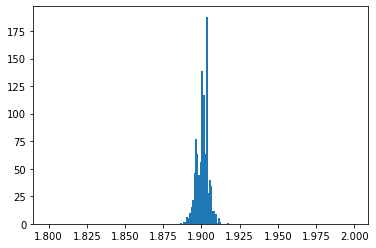

In [115]:
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'



agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

detected_data = detected_sample_en1[~agn_mask]
mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
detected_data = detected_data[mask]


limit_data = limit_sample_en1
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]


num = 1000
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    median_q.append(kmf.median_survival_time_)
    kmfs.append(kmf)

plt.hist(median_q,bins=np.arange(1.8,2.0,0.001))
plt.show()


number of sources in redshift bin: 0.05  is: 18
number of sources in redshift bin: 0.15000000000000002  is: 271
number of sources in redshift bin: 0.25  is: 1235
number of sources in redshift bin: 0.35000000000000003  is: 1742
number of sources in redshift bin: 0.45  is: 2248
number of sources in redshift bin: 0.55  is: 3009
number of sources in redshift bin: 0.6500000000000001  is: 3991
number of sources in redshift bin: 0.7500000000000001  is: 3473
number of sources in redshift bin: 0.8500000000000001  is: 4211
number of sources in redshift bin: 0.9500000000000001  is: 3959
values: [ 2.0352743  -0.14801088]
errors: [[ 0.00244144 -0.00229931]
 [-0.00229931  0.00227569]]
---------------------------------
values: [ 2.05938009 -0.18109793]
errors: [[ 0.00128878 -0.00118661]
 [-0.00118661  0.00114757]]
---------------------------------
values: [ 2.15165005 -0.24774739]
errors: [[ 0.00126979 -0.00109767]
 [-0.00109767  0.00098142]]
---------------------------------
values: [ 2.05705911 -0.

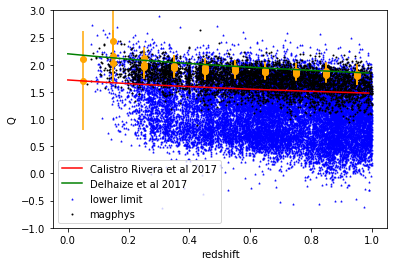

In [212]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the each redshift bin and find the median q in each redshift bin to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'



agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

detected_data = detected_sample_en1
mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name]))
detected_data = detected_data[mask]


limit_data = limit_sample_en1
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]


mask_det = det.astype(bool)
x = limit_data['Z_BEST']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',label='lower limit',c='blue')

x = detected_data['Z_BEST']
y = detected_data[det_name]
plt.scatter(x,y,s=1,label=sed_name,c='black')

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.01)
y = delhaize_fit(x)
plt.plot(x,y,c='green',label='Delhaize et al 2017')





data = np.append(detected_data[det_name],limit_data[lim_name])
#data[flag_detected] = q_lim[flag_detected]
det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))

redshift_det = detected_data['Z_BEST']
ldust_det = detected_data[ldust_name]

redshift_lim = limit_data['Z_BEST']
ldust_lim = limit_data[ldust_name]

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

median_q.append(kmf.median_survival_time_)
kmfs.append(kmf)




bins_z = np.arange(0,1.0,0.1)

redshifts = np.append(redshift_det,redshift_lim)

test = np.digitize(redshifts,bins=bins_z)
nums_z,counts = np.unique(test,return_counts=True)

ras_binned = []
decs_binned = []
redshift_plot = []
mean_q_agnfitter = []
median_q_err = []
for m,num in enumerate(nums_z):
    mask = (test==num) #& (redshift_all<np.max(redshift))
    print('number of sources in redshift bin: {}  is: {}'.format(bins_z[m]+0.05,np.sum(mask)))
    q_vals = data[mask]
    q_det = det[mask]

    n_samples = int(len(q_vals)*0.2)
    n_bootstrap = 5
    q_num_bootstrap = bootstrap(np.arange(0,len(q_vals),1),n_bootstrap,n_samples).astype(int)

    for i,q_nums in enumerate(q_num_bootstrap): 


        redshift_plot.append(bins_z[m])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals[q_nums], q_det[q_nums],label='Kaplan Meier Estimate')
        


        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)

x = np.array(redshift_plot)+0.05
y = np.array(mean_q_agnfitter)
plt.scatter(x,y,c='orange')
yerr = np.array(median_q_err)
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

for n in range(n_bootstrap):
    x_fit = x[n::n_bootstrap]
    y_fit = y[n::n_bootstrap]
    y_err_fit = yerr[n::n_bootstrap]
    mask = (~np.isnan(y_fit)) & (~np.isinf(y_fit)) & (y_err_fit!=0)
    x_fit = x_fit[mask]
    y_fit = y_fit[mask]
    y_err_fit = y_err_fit[mask]
    po = [1.7,-0.2]
    popt,pcov = curve_fit(power_law,x_fit[2:],y_fit[2:],po,sigma=y_err_fit[2:])
    print('values: {}'.format(popt))
    print('errors: {}'.format(pcov))
    print('---------------------------------')
    
plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

[0.1197    0.458     0.56978   0.6313448 0.69056   0.74415   0.7977
 0.8444    0.897     0.9502    0.9999   ]


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


power law fit parameters: alpha = -0.073707 +\- 0.017603, N = 1.9294 +\- 0.01676


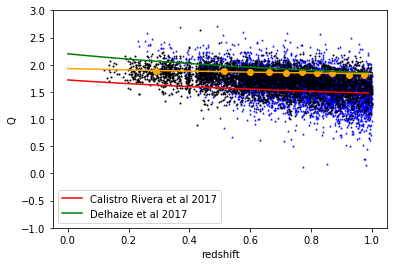

In [576]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'



agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

detected_data = detected_sample_en1[~agn_mask]
mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
detected_data = detected_data[mask]


limit_data = limit_sample_en1
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]


mask_det = det.astype(bool)
x = limit_data['Z_BEST']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Z_BEST']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black',)

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.01)
y = delhaize_fit(x)
plt.plot(x,y,c='green',label='Delhaize et al 2017')


redshifts = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 1000
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter   
    popt,pcov = curve_fit(power_law,x,y,po,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
    
plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

In [395]:
np.percentile(popts[:,1],5)

-0.2057042613329888

In [259]:
mask = test==11
redshifts[mask]

array([0.9999, 0.9999])

There are 696 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1389 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
median q = 2.1470256362708113


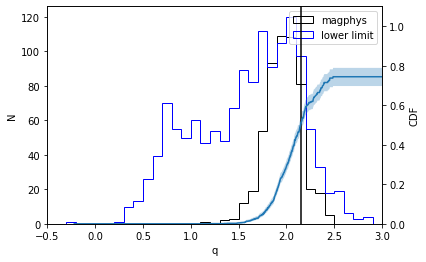

There are 2670 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 7267 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
median q = 2.0247012862707194


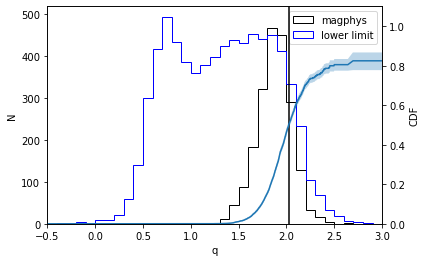

There are 3826 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 10976 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
median q = 1.9670467291258973


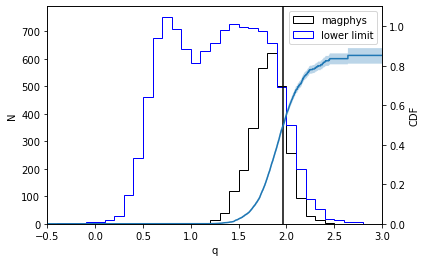

There are 4906 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 14724 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
median q = 1.9235620799511501


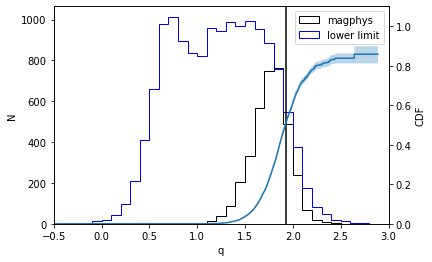

There are 6018 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 19833 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
median q = 1.9010384262333275


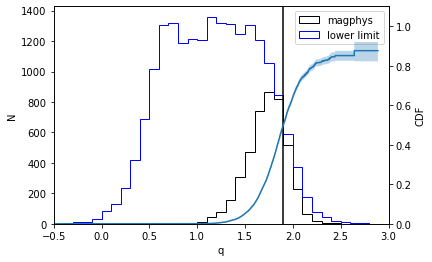

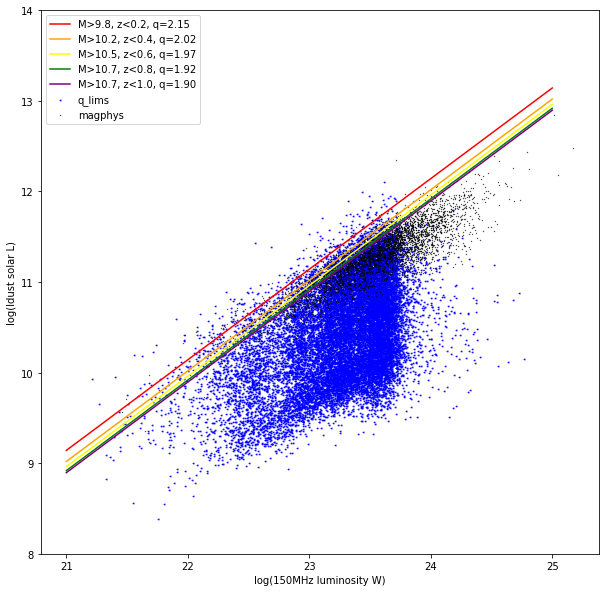

In [88]:
#evolution with different redshifts and stellar masses

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

sed_name = 'magphys'
ldust_name = 'Ldust_bayes'
rad_name = 'radio_luminosity'
ldust_lim_name = 'Ldust_bayes'
rad_lim_name = 'radio_luminosity_limit'

limits_z = [0.2,0.4,0.6,0.8,1.0]
limits_m = [9.75,10.2,10.5,10.65,10.7]

medians = []
for n in range(len(limits_z)):
    #create a mask to select a sample that is complete in stellar mass and redshift
    #for a mass complete sample at z<1.0 Mstar>10.7
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<limits_z[n]) & (lofar_sed_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_en1)))
    detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1]

    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<limits_z[n]) & (lofar_magphys_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_limit_en1)))
    limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1]

    agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

    detected_data = detected_sample_en1[det_name][~agn_mask]
    mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
    detected_data = detected_data[mask]
    redshift_det = detected_sample_en1['Z_BEST'][~agn_mask][mask]
    ldust_det = detected_sample_en1[ldust_name][~agn_mask][mask]

    limit_data = limit_sample_en1[lim_name]
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
    limit_data = limit_data[mask]
    redshift_lim = limit_sample_en1['Z_BEST'][mask]
    ldust_lim = limit_sample_en1[ldust_name][mask]

    data = np.append(detected_data,limit_data)
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    print('median q = {}'.format(kmf.median_survival_time_))
    medians.append(kmf.median_survival_time_)
    

    bins = np.arange(-3,4,0.1)
    fig,ax1 = plt.subplots()

    ax1.hist(detected_sample_en1[det_name][~agn_mask],label=sed_name,bins=bins,histtype='step',color='black')
    ax1.hist(limit_sample_en1[lim_name],label='lower limit',bins=bins,histtype='step',color='blue')

    ax2 = ax1.twinx()
    x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
    y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
    ax2.plot(x,y)
    lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
    upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
    ax2.fill_between(x,lowx,upx,alpha=0.3)
    ax2.set_ylabel('CDF')

    plt.vlines(kmf.median_survival_time_,0,2000)
    plt.ylim(0,1.1)
    plt.xlim(-0.5,3)
    ax1.set_xlabel('q')
    ax1.set_ylabel('N')
    ax1.legend()
    plt.show()
    
fig,ax = plt.subplots(figsize=(10,10))
y = np.log10(limit_sample_en1[ldust_lim_name]/3.8E26)
x = np.log10(limit_sample_en1[rad_lim_name])
ax.scatter(x,y,s=1,label='q_lims',c='blue',marker='<')

x = np.log10(detected_sample_en1[rad_name][~agn_mask])
y = np.log10(detected_sample_en1[ldust_name][~agn_mask]/3.8E26)
ax.scatter(x,y,s=0.1,label='magphys',c='black')

x = np.arange(21,25.5,0.5)
colors = ['red','orange','yellow','green','purple']

for n,med in enumerate(medians):
    label = f'M>{limits_m[n]:2.1f}, z<{limits_z[n]:2.1f}, q={med:2.2f}'
    y = x + med - np.log10(3.8E26) + np.log10(3.75E12)
    ax.plot(x,y,c=colors[n],label=label)

ax.set_xlabel('log(150MHz luminosity W)')
ax.set_ylabel('log(ldust solar L)')
ax.set_ylim(8.0,14)
ax.legend()
plt.show()


There are 2670 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 7267 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
median q = 2.0247012862707194


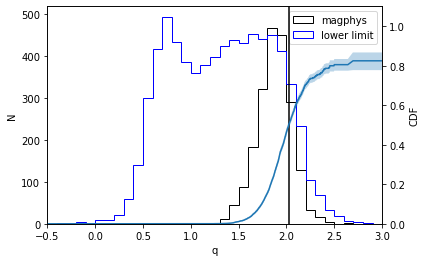

There are 1785 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 4124 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
median q = 2.003805521766168


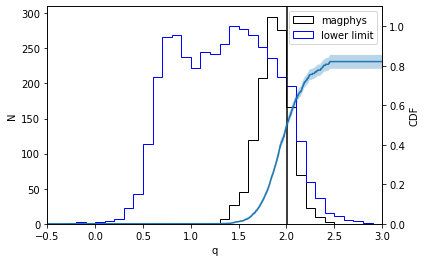

There are 1310 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2861 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
median q = 2.001226043690721


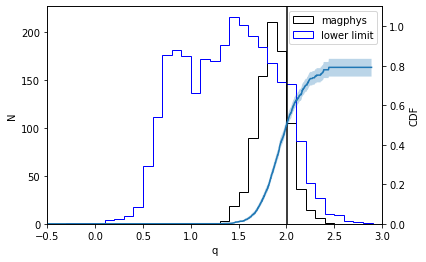

There are 1178 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 2526 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
median q = 1.9959925423722886


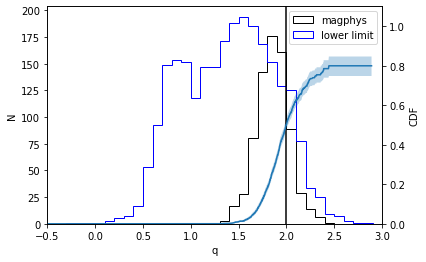

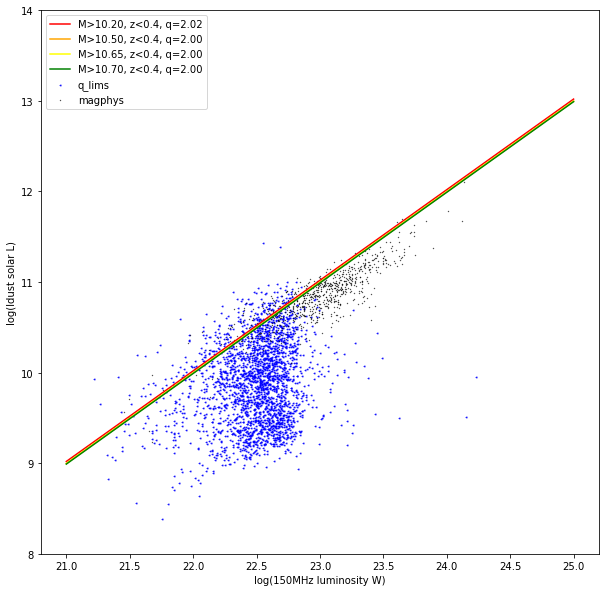

In [22]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

sed_name = 'magphys'
ldust_name = 'Ldust_bayes'
rad_name = 'radio_luminosity'
ldust_lim_name = 'Ldust_bayes'
rad_lim_name = 'radio_luminosity_limit'

limits_m = [10.2,10.5,10.65,10.7]

medians = []
for n in range(len(limits_m)):
    #create a mask to select a sample that is complete in stellar mass and redshift
    #for a mass complete sample at z<1.0 Mstar>10.7
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (lofar_sed_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_en1)))
    detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1]

    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (lofar_magphys_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_limit_en1)))
    limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1]

    agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

    detected_data = detected_sample_en1[det_name][~agn_mask]
    mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
    detected_data = detected_data[mask]
    redshift_det = detected_sample_en1['Z_BEST'][~agn_mask][mask]
    ldust_det = detected_sample_en1[ldust_name][~agn_mask][mask]

    limit_data = limit_sample_en1[lim_name]
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
    limit_data = limit_data[mask]
    redshift_lim = limit_sample_en1['Z_BEST'][mask]
    ldust_lim = limit_sample_en1[ldust_name][mask]

    data = np.append(detected_data,limit_data)
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    print('median q = {}'.format(kmf.median_survival_time_))
    medians.append(kmf.median_survival_time_)
    

    bins = np.arange(-3,4,0.1)
    fig,ax1 = plt.subplots()

    ax1.hist(detected_sample_en1[det_name][~agn_mask],label=sed_name,bins=bins,histtype='step',color='black')
    ax1.hist(limit_sample_en1[lim_name],label='lower limit',bins=bins,histtype='step',color='blue')

    ax2 = ax1.twinx()
    x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
    y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
    ax2.plot(x,y)
    lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
    upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
    ax2.fill_between(x,lowx,upx,alpha=0.3)
    ax2.set_ylabel('CDF')

    plt.vlines(kmf.median_survival_time_,0,2000)
    plt.ylim(0,1.1)
    plt.xlim(-0.5,3)
    ax1.set_xlabel('q')
    ax1.set_ylabel('N')
    ax1.legend()
    plt.show()

fig,ax = plt.subplots(figsize=(10,10))
y = np.log10(limit_sample_en1[ldust_lim_name]/3.8E26)
x = np.log10(limit_sample_en1[rad_lim_name])
ax.scatter(x,y,s=1,label='q_lims',c='blue',marker='<')

x = np.log10(detected_sample_en1[rad_name][~agn_mask])
y = np.log10(detected_sample_en1[ldust_name][~agn_mask]/3.8E26)
ax.scatter(x,y,s=0.1,label='magphys',c='black')

x = np.arange(21,25.5,0.5)
colors = ['red','orange','yellow','green','purple']

for n,med in enumerate(medians):
    label = f'M>{limits_m[n]:2.2f}, z<{0.4}, q={med:2.2f}'
    y = x + med - np.log10(3.8E26) + np.log10(3.75E12)
    ax.plot(x,y,c=colors[n],label=label)

ax.set_xlabel('log(150MHz luminosity W)')
ax.set_ylabel('log(ldust solar L)')
ax.set_ylim(8.0,14)
ax.legend()
plt.show()



There are 1692 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1331 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
[10.1990494  10.24430838 10.29113693 10.33760042 10.395327   10.44909906
 10.51558838 10.59446392 10.68691387 10.82765608 11.50807722]
power law fit parameters: alpha = -0.16031 +\- 0.01562, N = 2.0721 +\- 0.012849
There are 1748 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1331 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
[10.1990494  10.2446455  10.2919384  10.33882227 10.39681377 10.45136499
 10.51910515 10.59763184 10.68932724 10.82999735 11.50807722]
power law fit parameters: alpha = -0.15687 +\- 0.015651, N = 2.0646 +\- 0.012635


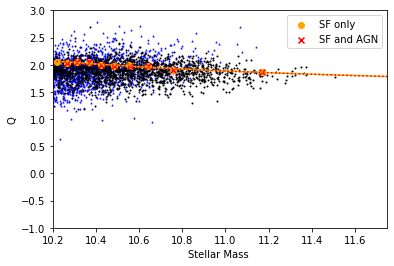

In [594]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7
 
mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (lofar_sed_en1['Mass_median']>10.2)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))



mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (lofar_magphys_en1['Mass_median']>10.2)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median']) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]



mask_det = det.astype(bool)
x = limit_data['Mass_median']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Mass_median']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')




redshifts = np.append(detected_data['Mass_median'],limit_data['Mass_median'])
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001
print(bins_z)


num = 1000
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Mass_median'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Mass_median'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(power_law,x[mask]-10.2,y[mask],po,sigma=yerr[mask])
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange',label='SF only')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,2,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x+10.2,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
 
#repeat the process but without removing AGN

mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (lofar_sed_en1['Mass_median']>10.2)# & mask_loc
SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))>-10.5
detected_data = lofar_sed_en1[mask_mass_complete_en1 & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))



mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (lofar_magphys_en1['Mass_median']>10.2)# & mask_loc
SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median']) > -10.5
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]

redshifts = np.append(detected_data['Mass_median'],limit_data['Mass_median'])
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001
print(bins_z)


num = 1000
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))
    
    redshift_det = detected_data['Mass_median'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    
    redshift_lim = limit_data['Mass_median'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for m,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if m==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)
    
    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(power_law,x[mask]-10.2,y[mask],po,sigma=yerr[mask])
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='red',marker='x',label='SF and AGN')
plt.errorbar(x,y,yerr=yerr,c='red',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,2,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x+10.2,y,c='red',linestyle='dotted')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
 




plt.xlim(10.2,11.75)
plt.ylim(-1,3)
plt.xlabel('Stellar Mass ')
plt.ylabel('Q')
plt.legend()
plt.show()

In [593]:
median_q_err

[-0.1593895632754908,
 -0.1741761876611998,
 -0.17002473229085158,
 -0.13996066003506935,
 -0.13884695753893417,
 -0.12843680120654377,
 -0.13425146501679852,
 -0.13635045100663523,
 -0.12172108820799432,
 -0.11762689938218662]

In [586]:
mask = (test==0) #& (redshift_all<np.max(redshift))
data[mask]

array([], dtype=float64)

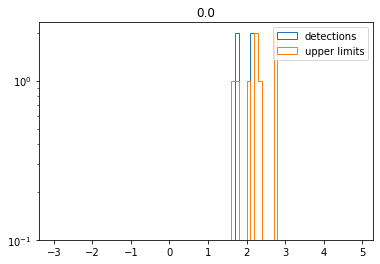

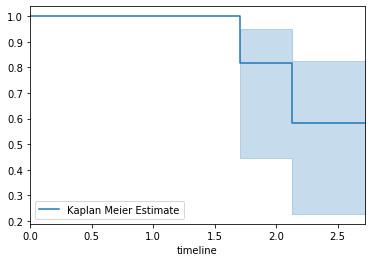

measured median using survival analysis is: inf


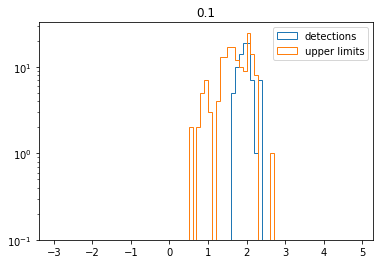

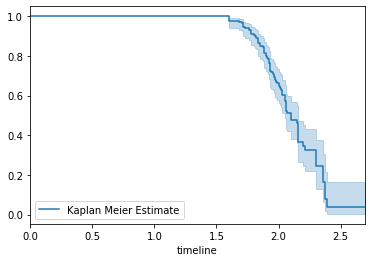

measured median using survival analysis is: 2.09685687905791


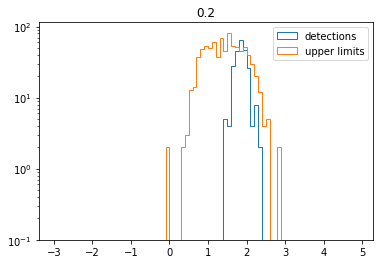

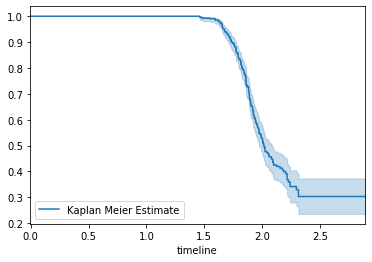

measured median using survival analysis is: 2.0149878797057994


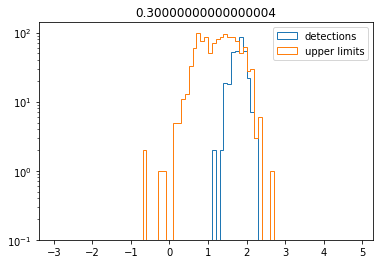

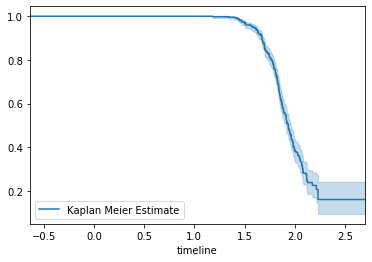

measured median using survival analysis is: 1.9356228159450595


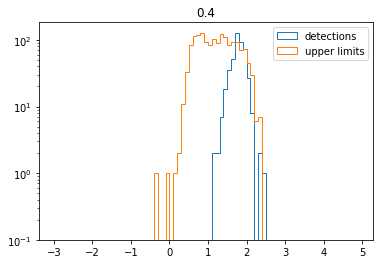

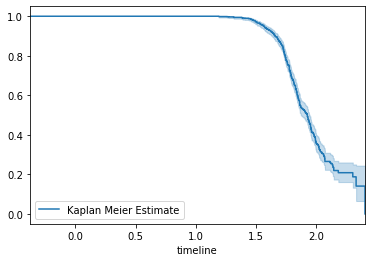

measured median using survival analysis is: 1.9254674028578798


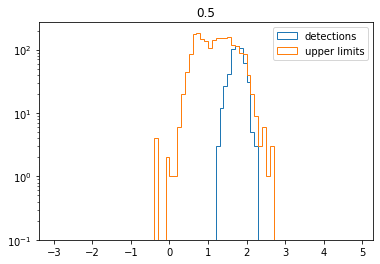

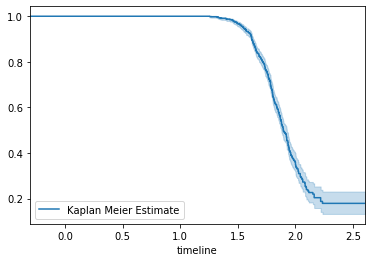

measured median using survival analysis is: 1.8951498968376264


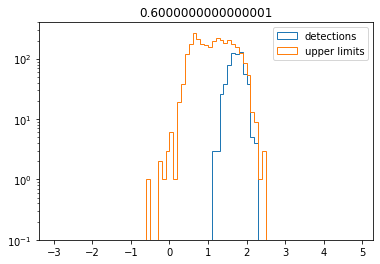

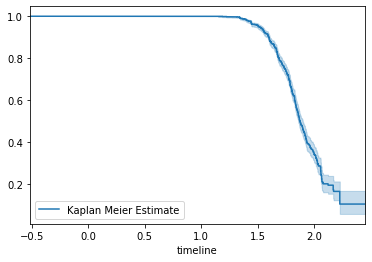

measured median using survival analysis is: 1.8756098820894032


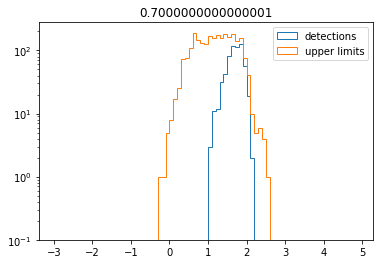

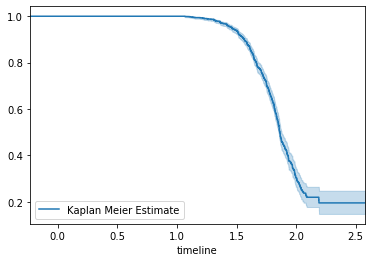

measured median using survival analysis is: 1.8629899416024926


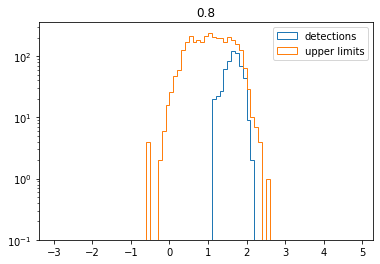

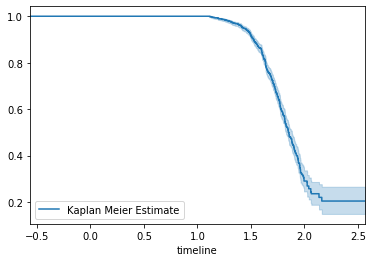

measured median using survival analysis is: 1.8545493129345871


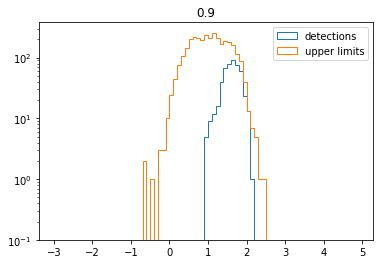

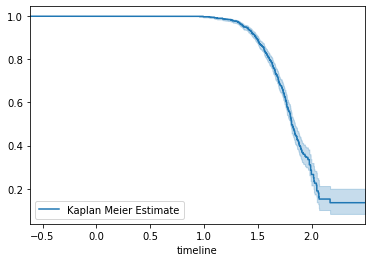

measured median using survival analysis is: 1.8130240477750341


In [164]:
bins_z = np.arange(0,1.0,0.1)
bins_z = []
percentiles = np.arange(0,1,0.1)
data_z
mask_z = 
for n,percent in enumerate(percentiles):
    bins_z

redshifts = np.append(redshift_det,redshift_lim)

test = np.digitize(redshifts,bins=bins_z)
nums_z,counts = np.unique(test,return_counts=True)

ras_binned = []
decs_binned = []
redshift_binned = []
mean_q_agnfitter = []
median_q_err = []
for n,num in enumerate(nums_z):
    mask = (test==num) #& (redshift_all<np.max(redshift))
    q_vals = data[mask]
    q_det = det[mask]
    q_lims = data[mask][~det[mask].astype(bool)]
    
    redshift_binned.append(redshifts[mask])
    
    bins = np.arange(-3,5,0.1)
    plt.hist(q_vals[det[mask].astype(bool)],log=True,label='detections',bins=bins,histtype='step')
    plt.hist(q_lims,log=True,label='upper limits',bins=bins,histtype='step')
    plt.title('{}'.format(bins_z[n]))
    plt.legend()
    plt.show()
    
    '''plt.hist(redshifts[mask],bins=np.arange(0,5,0.25),log=True,histtype='step')
    plt.xlabel('redshift')
    plt.title('{}'.format(bins_z[n]))
    plt.show()'''
    
    
    kmf = KaplanMeierFitter()
    kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
    kmf.plot()
    plt.show()
    print('measured median using survival analysis is: {}'.format(kmf.median_))
    
    x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
    x = np.arange(-1,3,0.01)

    lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
    lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
    upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
    upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

    err = upx-lowx
    
    mean_q_agnfitter.append(kmf.median_)
    median_q_err.append(err)

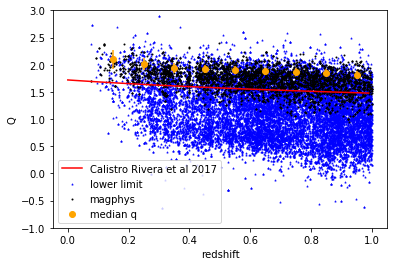

In [165]:
mask_det = det.astype(bool)
x = redshifts[~mask_det]
y = data[~mask_det]
plt.scatter(x,y,s=1,marker='^',label='lower limit',c='blue')

x = redshifts[mask_det]
y = data[mask_det]
plt.scatter(x,y,s=1,label=sed_name,c='black')

x = bins_z[nums_z-1]+0.05
y = mean_q_agnfitter
plt.scatter(x,y,label='median q',c='orange')
yerr = median_q_err
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

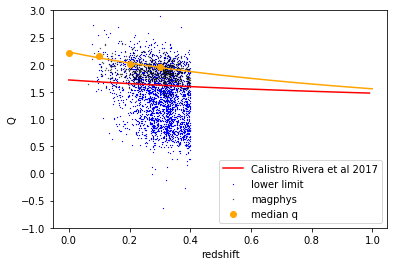

N = 2.234102869664926
a = -0.5211257343432607


In [25]:
#fit a power law to the median q's
x = bins_z[nums_z-1]
y = mean_q_agnfitter
po = [2,-0.2]
popt,pcov = curve_fit(power_law,x,y,po)

mask_det = det.astype(bool)
x = redshifts[~mask_det]
y = data[~mask_det]
plt.scatter(x,y,s=0.1,marker='^',label='lower limit',c='blue')

x = redshifts[mask_det]
y = data[mask_det]
plt.scatter(x,y,s=0.1,label=sed_name,c='black')

x = bins_z[nums_z-1]
y = mean_q_agnfitter
plt.scatter(x,y,label='median q',c='orange')

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x,y,c='orange')

plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()
print('N = {}'.format(popt[0]))
print('a = {}'.format(popt[1]))

### Run for different selections of mass and redshift

There are 696 galaxies detected in the radio with a stellar mass>9.75 and z<0.2
There are 1389 galaxies with only a Ldust measurement with a stellar mass>9.75 and z<0.2
1.5224604453725945
measured median from the detections is: 1.8229736285369036
measured median using survival analysis is: 2.1470256362708113
median q = 2.1470256362708113
There are 2670 galaxies detected in the radio with a stellar mass>10.2 and z<0.4
There are 7267 galaxies with only a Ldust measurement with a stellar mass>10.2 and z<0.4


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


1.9604460484428117
measured median from the detections is: 1.5631493230369333
measured median using survival analysis is: 2.0247012862707194
median q = 2.0247012862707194
There are 3826 galaxies detected in the radio with a stellar mass>10.5 and z<0.6
There are 10976 galaxies with only a Ldust measurement with a stellar mass>10.5 and z<0.6
1.9604460484428117
measured median from the detections is: 1.4751832390163138
measured median using survival analysis is: 1.9670467291258973
median q = 1.9670467291258973
There are 4906 galaxies detected in the radio with a stellar mass>10.65 and z<0.8
There are 14724 galaxies with only a Ldust measurement with a stellar mass>10.65 and z<0.8
1.5279370507206202
measured median from the detections is: 1.4099154250940504
measured median using survival analysis is: 1.9235620799511501
median q = 1.9235620799511501
There are 6018 galaxies detected in the radio with a stellar mass>10.7 and z<1.0
There are 19833 galaxies with only a Ldust measurement with a 

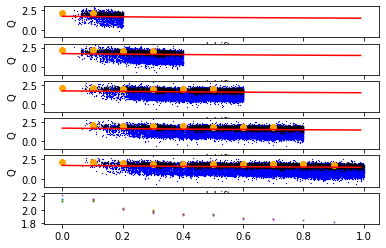

In [29]:
limits_z = [0.2,0.4,0.6,0.8,1.0]
limits_m = [9.75,10.2,10.5,10.65,10.7]
columns = len(limits_z) + 1

fig,axs = plt.subplots(columns,1,sharex='col')
for n in range(len(limits_m)):
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<limits_z[n]) & (lofar_sed_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies detected in the radio with a stellar mass>{} and z<{}'.format(np.sum(mask_mass_complete_en1),limits_m[n],limits_z[n]))
    detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1]

    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<limits_z[n]) & (lofar_magphys_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies with only a Ldust measurement with a stellar mass>{} and z<{}'.format(np.sum(mask_mass_complete_limit_en1),limits_m[n],limits_z[n]))
    limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1]
    
    '''for m,q_col in enumerate(q_use_det):
        det_name = q_col
        if m==0:
            lim_name = 'q_lim'
        else:
            lim_name = q_col+'_lim'
'''

    det_name = 'q_magphys'
    lim_name = 'q_lim'
    ldust_name = 'Ldust_bayes'

    agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

    detected_data = detected_sample_en1[det_name][~agn_mask]
    print(detected_data[0])
    mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
    detected_data = detected_data[mask]
    redshift_det = detected_sample_en1['Z_BEST'][~agn_mask][mask]
    ldust_det = detected_sample_en1[ldust_name][~agn_mask][mask]

    limit_data = limit_sample_en1[lim_name]
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
    limit_data = limit_data[mask]
    redshift_lim = limit_sample_en1['Z_BEST'][mask]
    ldust_lim = limit_sample_en1[ldust_name][mask]

    data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
    print('measured median from the detections is: {}'.format(np.median(data)))
    kmf = KaplanMeierFitter() 

## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
    print('measured median using survival analysis is: {}'.format(kmf.median_survival_time_))
    print('median q = {}'.format(kmf.median_survival_time_))

    bins_z = np.arange(0,1.0,0.1)

    redshifts = np.append(redshift_det,redshift_lim)

    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    for m,num in enumerate(nums_z):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]
    
        redshift_binned.append(redshifts[mask])
        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        mean_q_agnfitter.append(kmf.median_)
        
    mask_det = det.astype(bool)
    x = redshifts[~mask_det]
    y = data[~mask_det]
    axs[n].scatter(x,y,s=0.1,marker='^',label='lower limit',c='blue')

    x = redshifts[mask_det]
    y = data[mask_det]
    axs[n].scatter(x,y,s=0.1,label=sed_name,c='black')

    x = bins_z[nums_z-1]
    y = mean_q_agnfitter
    axs[n].scatter(x,y,label='median q',c='orange')
    axs[columns-1].scatter(x,y,s=1)

    x = np.arange(0,1,0.01)
    y = calistro_fit(x)
    axs[n].plot(x,y,c='red',label='Calistro Rivera et al 2017')

    axs[n].set_ylim(-1,3)
    axs[n].set_xlabel('redshift')
    axs[n].set_ylabel('Q')

plt.show()


There are 696 galaxies detected in the radio with a stellar mass>9.75 and z<0.2
There are 1389 galaxies with only a Ldust measurement with a stellar mass>9.75 and z<0.2
1.5224604453725945
median q = 2.1470256362708113
-21.446429133650472
median q = -20.36961518495006


/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


-21.618582903220243
median q = -20.50056962045371
-22.54654681358211
median q = -20.442060602262316
There are 2670 galaxies detected in the radio with a stellar mass>10.2 and z<0.4
There are 7267 galaxies with only a Ldust measurement with a stellar mass>10.2 and z<0.4
1.9604460484428117
median q = 2.0247012862707194
-21.05849119874394
median q = -20.97211096457601
-21.15821862906486
median q = -20.83023427734184
-21.719874242312812
median q = -21.093288392512648
There are 3826 galaxies detected in the radio with a stellar mass>10.5 and z<0.6
There are 10976 galaxies with only a Ldust measurement with a stellar mass>10.5 and z<0.6
1.9604460484428117
median q = 1.9670467291258973
-21.05849119874394
median q = -21.209831393872392
-21.15821862906486
median q = -21.004492936209047
-21.719874242312812
median q = -21.26759627587042
There are 4906 galaxies detected in the radio with a stellar mass>10.65 and z<0.8
There are 14724 galaxies with only a Ldust measurement with a stellar mass>10.65

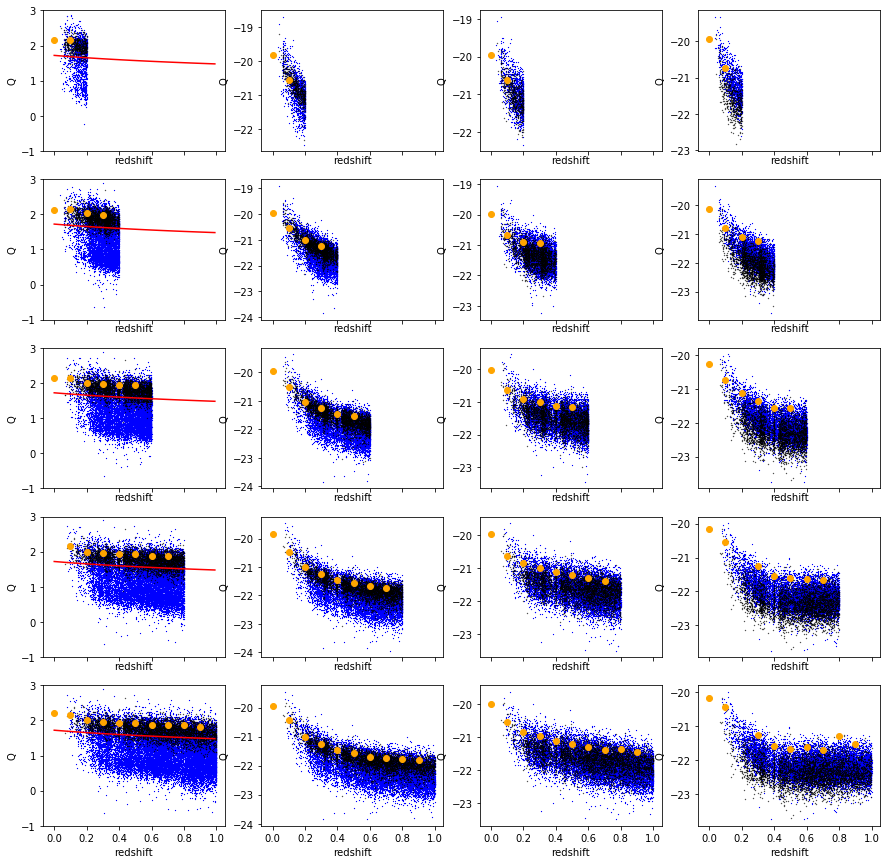

In [43]:
limits_z = [0.2,0.4,0.6,0.8,1.0]
limits_m = [9.75,10.2,10.5,10.65,10.7]
q_use_det = ['q_magphys','q_250','q_350','q_500']
k_fac = ['kcorr_250','kcorr_350','kcorr_500']
ldust_name = ['Ldust_bayes','F_SPIRE_250','F_SPIRE_350','F_SPIRE_500']
rad_name = 'radio_luminosity'
rad_lim_name = 'radio_luminosity_limit'

rows = len(limits_m)
columns = len(q_use_det)
fig,axs = plt.subplots(rows,columns,sharex='col',figsize=(15,15))
for n in range(len(limits_m)):
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<limits_z[n]) & (lofar_sed_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies detected in the radio with a stellar mass>{} and z<{}'.format(np.sum(mask_mass_complete_en1),limits_m[n],limits_z[n]))
    detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1]

    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<limits_z[n]) & (lofar_magphys_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies with only a Ldust measurement with a stellar mass>{} and z<{}'.format(np.sum(mask_mass_complete_limit_en1),limits_m[n],limits_z[n]))
    limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1]
    
    for m,q_col in enumerate(q_use_det):
        det_name = q_col
        if m==0:
            lim_name = 'q_lim'
        else:
            lim_name = q_col+'_lim'

        det_name = q_col
        if m==0:
            lim_name = 'q_lim'
        else:
            lim_name = q_col+'_lim'
        #ldust_name = 'Ldust_bayes'

        agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)
    #the k correction need to be logged as they are the factor
    #that the FIR flux needs to be divided by in order to get
    #the emitted FIR flux. Once logged 
        if m==0:
            kcor_det = 0
            kcor_lim = 0
        else:
            kcor_det = np.log10(detected_sample_en1[k_fac[m-1]])[~agn_mask]
            kcor_lim = np.log10(limit_sample_en1[k_fac[m-1]])
            
        detected_data = detected_sample_en1[det_name][~agn_mask] - kcor_det
        print(detected_data[0])
        mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
        detected_data = detected_data[mask]
        redshift_det = detected_sample_en1['Z_BEST'][~agn_mask][mask]
        ldust_det = detected_sample_en1[ldust_name[m]][~agn_mask][mask]
    
        limit_data = limit_sample_en1[lim_name] - kcor_lim
        mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
        limit_data = limit_data[mask]
        redshift_lim = limit_sample_en1['Z_BEST'][mask]
        ldust_lim = limit_sample_en1[ldust_name[m]][mask]

        data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
        kmf = KaplanMeierFitter()

## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')
        medians.append(kmf.median_survival_time_)

## Create an estimate
        print('median q = {}'.format(kmf.median_survival_time_))

        bins_z = np.arange(0,1.0,0.1)

        redshifts = np.append(redshift_det,redshift_lim)

        test = np.digitize(redshifts,bins=bins_z)
        nums_z,counts = np.unique(test,return_counts=True)

        ras_binned = []
        decs_binned = []
        redshift_binned = []
        mean_q_agnfitter = []
        for i,num in enumerate(nums_z):
            mask = (test==num) #& (redshift_all<np.max(redshift))
            q_vals = data[mask]
            q_det = det[mask]
            q_lims = data[mask][~det[mask].astype(bool)]
    
            redshift_binned.append(redshifts[mask])
            kmf = KaplanMeierFitter()
            kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
            mean_q_agnfitter.append(kmf.median_)
        
        mask_det = det.astype(bool)
        x = redshifts[~mask_det]
        y = data[~mask_det]
        axs[n,m].scatter(x,y,s=0.1,marker='^',label='lower limit',c='blue')

        x = redshifts[mask_det]
        y = data[mask_det]
        axs[n,m].scatter(x,y,s=0.1,label=sed_name,c='black')

        x = bins_z[nums_z-1]
        y = mean_q_agnfitter
        axs[n,m].scatter(x,y,label='median q',c='orange')
        if m==0:
            x = np.arange(0,1,0.01)
            y = calistro_fit(x)
            axs[n,m].plot(x,y,c='red',label='Calistro Rivera et al 2017')

        axs[n,m].set_xlabel('redshift')
        axs[n,m].set_ylabel('Q')
        
for n in range(rows):
    axs[n,0].set_ylim(-1,3)

plt.show()



In [32]:
sed_name = 'magphys'
ldust_name = 'Ldust_bayes'
rad_name = 'radio_luminosity'
ldust_lim_name = 'Ldust_bayes'
rad_lim_name = 'radio_luminosity_limit'

There are 696 galaxies detected in the radio with a stellar mass>9.75 and z<0.2
There are 1389 galaxies with only a Ldust measurement with a stellar mass>9.75 and z<0.2
median q = 2.1470256362708113
median q = -20.515870399630487
median q = -20.72047305657662
median q = -20.507090575143426
There are 2670 galaxies detected in the radio with a stellar mass>10.2 and z<0.4
There are 7267 galaxies with only a Ldust measurement with a stellar mass>10.2 and z<0.4
median q = 2.1592156940036613
median q = -20.97211096457601
median q = -20.83023427734184
median q = -21.093288392512648
There are 3826 galaxies detected in the radio with a stellar mass>10.5 and z<0.6
There are 10976 galaxies with only a Ldust measurement with a stellar mass>10.5 and z<0.6
median q = 2.2292751898100147
median q = -21.209831393872392
median q = -21.004492936209047
median q = -21.26759627587042
There are 4906 galaxies detected in the radio with a stellar mass>10.65 and z<0.8
There are 14724 galaxies with only a Ldust 

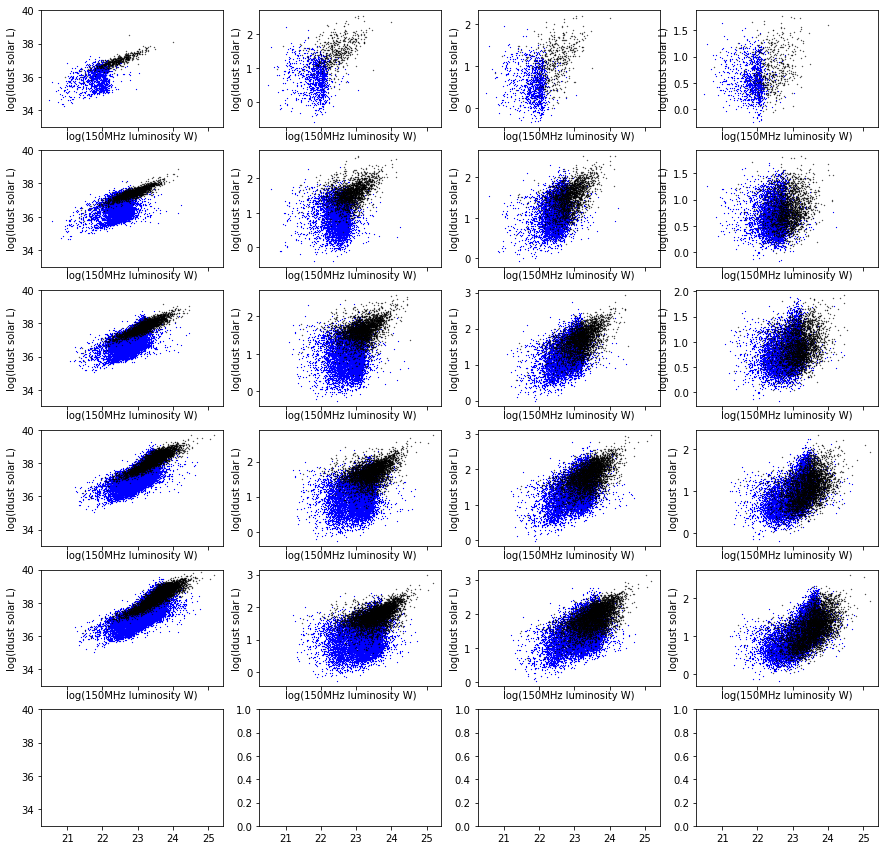

In [44]:
limits_z = [0.2,0.4,0.6,0.8,1.0]
limits_m = [9.75,10.2,10.5,10.65,10.7]
q_use_det = ['q_magphys','q_250','q_350','q_500']
k_fac = ['kcorr_250','kcorr_350','kcorr_500']
ldust_name = ['Ldust_bayes','F_SPIRE_250','F_SPIRE_350','F_SPIRE_500']
rad_name = 'radio_luminosity'
rad_lim_name = 'radio_luminosity_limit'

rows = len(limits_z) + 1
columns = len(q_use_det)
fig,axs = plt.subplots(rows,columns,sharex='col',figsize=(15,15))
q_medians = []
for n in range(len(limits_m)):
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<limits_z[n]) & (lofar_sed_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies detected in the radio with a stellar mass>{} and z<{}'.format(np.sum(mask_mass_complete_en1),limits_m[n],limits_z[n]))
    detected_sample_en1 = lofar_sed_en1[mask_mass_complete_en1]

    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<limits_z[n]) & (lofar_magphys_en1['Mass_median']>limits_m[n])
    print('There are {} galaxies with only a Ldust measurement with a stellar mass>{} and z<{}'.format(np.sum(mask_mass_complete_limit_en1),limits_m[n],limits_z[n]))
    limit_sample_en1 = lofar_magphys_en1[mask_mass_complete_limit_en1]
    medians = []
    for m,q_col in enumerate(q_use_det):
        det_name = q_col
        if m==0:
            lim_name = 'q_lim'
        else:
            lim_name = q_col+'_lim'
        #ldust_name = 'Ldust_bayes'

        agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)
    #the k correction need to be logged as they are the factor
    #that the FIR flux needs to be divided by in order to get
    #the emitted FIR flux. Once logged 
        if n==0:
            kcor_det = 0
            kcor_lim = 0
        else:
            kcor_det = np.log10(detected_sample_en1[k_fac[m-1]])[~agn_mask]
            kcor_lim = np.log10(limit_sample_en1[k_fac[m-1]])
            
        detected_data = detected_sample_en1[det_name][~agn_mask] - kcor_det
        mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
        detected_data = detected_data[mask]
        redshift_det = detected_sample_en1['Z_BEST'][~agn_mask][mask]
        ldust_det = detected_sample_en1[ldust_name[m]][~agn_mask][mask]
    
        limit_data = limit_sample_en1[lim_name] - kcor_lim
        mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
        limit_data = limit_data[mask]
        redshift_lim = limit_sample_en1['Z_BEST'][mask]
        ldust_lim = limit_sample_en1[ldust_name[m]][mask]

        data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
        kmf = KaplanMeierFitter()

## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')
        medians.append(kmf.median_survival_time_)

## Create an estimate
        print('median q = {}'.format(kmf.median_survival_time_))
    
        y = np.log10(limit_sample_en1[ldust_name[m]]) - kcor_lim
        x = np.log10(limit_sample_en1[rad_lim_name])
        axs[n,m].scatter(x,y,s=0.1,label='q_lims',c='blue',marker='^')
       
        x = np.log10(detected_sample_en1[rad_name][~agn_mask])
        y = np.log10(detected_sample_en1[ldust_name[m]][~agn_mask]) - kcor_det
        axs[n,m].scatter(x,y,s=0.1,label='magphys',c='black')

        axs[n,m].set_xlabel('log(150MHz luminosity W)')
        axs[n,m].set_ylabel('log(ldust solar L)')
    q_medians.append(medians)

for n in range(rows):
    axs[n,0].set_ylim(33,40)
plt.show()



In [35]:
x = bins_z[nums_z-1]
y = calistro_fit(x)
dif = np.mean(mean_q_agnfitter - y)
print(dif)

0.4462882740431955


In [36]:
bins_z = np.arange(0,1.0,0.1)

redshifts = np.append(redshift_det,redshift_lim)
ldusts = np.append(np.log10(ldust_det),np.log10(ldust_lim))

mask_ldust = ldusts>38

test = np.digitize(redshifts[mask_ldust],bins=bins_z)
nums_z,counts = np.unique(test,return_counts=True)

ras_binned = []
decs_binned = []
redshift_binned = []
mean_q = []
for n,num in enumerate(nums_z):
    mask = (test==num) #& (redshift_all<np.max(redshift))
    q_vals = data[mask_ldust][mask]
    q_det = det[mask_ldust][mask]
    q_lims = data[mask_ldust][mask][~det[mask_ldust][mask].astype(bool)]
    
    redshift_binned.append(redshifts[mask_ldust][mask])
    
    bins = np.arange(-3,5,0.1)
    plt.hist(q_vals[det[mask_ldust][mask].astype(bool)],log=True,label='detections',bins=bins,histtype='step')
    plt.hist(q_lims,log=True,label='upper limits',bins=bins,histtype='step')
    plt.title('{}'.format(bins_z[n]))
    plt.legend()
    plt.show()
    
    plt.hist(redshifts[mask_ldust][mask],bins=np.arange(0,5,0.25),log=True,histtype='step')
    plt.xlabel('redshift')
    plt.title('{}'.format(bins_z[n]))
    plt.show()
    
    
    kmf = KaplanMeierFitter()
    kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
    kmf.plot()
    plt.show()
    print('measured median using survival analysis is: {}'.format(kmf.median_))
    
    mean_q.append(kmf.median_)

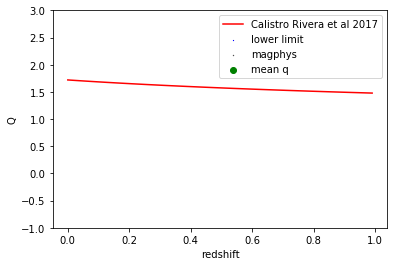

In [37]:
mask_det = det.astype(bool)
mask_bright = ldusts>38
x = redshifts[~mask_det & mask_bright]
y = data[~mask_det & mask_bright]
plt.scatter(x,y,s=0.1,marker='^',label='lower limit',c='blue')

x = redshifts[mask_det& mask_bright]
y = data[mask_det& mask_bright]
plt.scatter(x,y,s=0.1,label=sed_name,c='black')

x = bins_z[nums_z-1]
y = mean_q
plt.scatter(x,y,label='mean q',c='green')

x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

## See if the dispersion in q is dependent on any parameters

In [467]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

detected_data = detected_sample_en1[det_name][~agn_mask]
mask = (~np.isnan(detected_sample_en1[det_name][~agn_mask])) & (~np.isinf(detected_sample_en1[det_name][~agn_mask]))
detected_data = detected_data[mask]
redshift_det = detected_sample_en1['Z_BEST'][~agn_mask][mask]
ldust_det = detected_sample_en1[ldust_name][~agn_mask][mask]

limit_data = limit_sample_en1[lim_name]
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name]))
limit_data = limit_data[mask]
redshift_lim = limit_sample_en1['Z_BEST'][mask]
ldust_lim = limit_sample_en1[ldust_name][mask]

data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))


n_bootstrap = 1000
n_samples_data = int(len(data)*0.9)
bootstrap_data = bootstrap(np.arange(0,len(data),1),n_bootstrap,n_samples_data).astype(int)

medians = []
errs = []
for n,nums in enumerate(bootstrap_data):
    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data[bootstrap_data[n]], det[bootstrap_data[n]],label='Kaplan Meier Estimate')

    ## Create an estimate

    x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
    x = np.arange(-1,3,0.01)
    lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
    lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
    upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
    upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

    err = upx-lowx
    medians.append(kmf.median_survival_time_)
    errs.append(err)
print('q = {} +/- {}'.format(np.mean(medians),np.std(medians)))
print('where the error is the standard error of the bootstrapped medians')

q_median = np.mean(medians)
q_std = np.std(medians)


q = 1.9009748817604084 +/- 0.004549427742458357
where the error is the standard error of the bootstrapped medians


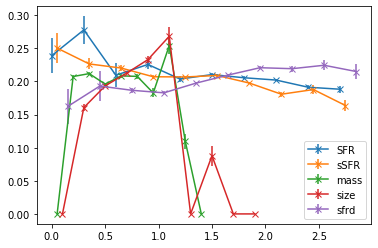

In [533]:
sed_name = 'magphys'
ldust_name = 'Ldust_bayes'
rad_name = 'radio_luminosity'
ldust_lim_name = 'Ldust_bayes'
rad_lim_name = 'radio_luminosity_limit'


'''x = np.log10(detected_sample_en1[rad_name][~agn_mask])
bins_x = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_x.append(np.percentile(x,percent))
bins_x = np.array(bins_x)


y = np.log10(detected_sample_en1[ldust_name][~agn_mask]/3.8E26)
bins_y = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_y.append(np.percentile(y,percent))
bins_y = np.array(bins_y)


z = np.log10(detected_sample_en1['SFR_bayes'])
mask = z>21
z = z[mask] - np.log10(3.8*10**26)
means = scipy.stats.binned_statistic_2d(x[mask],y[mask],z,statistic='mean',bins=[bins_x,bins_y])

plt.imshow(means[0].transpose())

x = np.arange(21,25.5,0.5)
y = x + kmf.median_survival_time_ - np.log10(3.8E26) + np.log10(3.75E12)
plt.plot(x,y,c='red')

plt.colorbar()
plt.show()'''
x = detected_sample_en1['q_magphys']
n_bootstrap = 100
n_samples_data = int(len(data)*0.9)
bootstrap_data = bootstrap(np.arange(0,len(x),1),n_bootstrap,n_samples_data).astype(int)

stds_sfr = np.zeros([n_bootstrap,10])
stds_ssfr = np.zeros([n_bootstrap,10])
stds_mass = np.zeros([n_bootstrap,10])
stds_size = np.zeros([n_bootstrap,10])
stds_sfrd = np.zeros([n_bootstrap,10])
for n,sample in enumerate(bootstrap_data):
    x = detected_sample_en1['q_magphys'][sample]
    mask = (~np.isnan(x)) & (~np.isinf(x))
    x = x[mask]
    y = np.log10(detected_sample_en1['SFR_bayes'][sample][mask])
    y = y - np.log10(3.8*10**26)

    bins_sfr = np.linspace(-1,2,11)
    stds,_,_ = scipy.stats.binned_statistic(y,x,statistic='std',bins=bins_sfr)
    stds_sfr[n] = stds

    
    y = np.log10(detected_sample_en1['SFR_bayes'][sample][mask]) - detected_sample_en1['Mass_median'][sample][mask]
    y = y - np.log10(3.8*10**26)

    bins_ssfr = np.linspace(-11.5,-8.5,11)
    stds,_,_ = scipy.stats.binned_statistic(y,x,statistic='std',bins=bins_ssfr)
    stds_ssfr[n] = stds
    
    y = detected_sample_en1['Mass_median'][sample][mask]

    bins_mass = np.linspace(10.5,12,11)
    stds,_,_ = scipy.stats.binned_statistic(y,x,statistic='std',bins=bins_mass)
    stds_mass[n] = stds
    
    y = np.log10(detected_sample_en1['Total_flux'][sample][mask]/detected_sample_en1['Peak_flux'][sample][mask])

    bins_size = np.linspace(-0.5,1.5,11)
    stds,_,_ = scipy.stats.binned_statistic(y,x,statistic='std',bins=bins_size)
    stds_size[n] = stds
    
    y = np.log10(detected_sample_en1['Total_flux'][sample][mask]/detected_sample_en1['Peak_flux'][sample][mask])
    sfr = np.log10(detected_sample_en1['SFR_bayes'][sample][mask]) - np.log10(3.8*10**26)
    y = y-sfr
    bins_sfrd = np.linspace(-2.5,0.5,11)
    stds,_,_ = scipy.stats.binned_statistic(y,x,statistic='mean',bins=bins_sfrd)
    stds_sfrd[n] = stds


    
x = get_center(bins_sfr) - np.min(get_center(bins_sfr))
y = np.mean(stds_sfr,axis=0)
yerr = np.std(stds_sfr,axis=0)
plt.errorbar(x,y,yerr=yerr,marker='x',label='SFR')

x = get_center(bins_ssfr) - np.min(get_center(bins_ssfr))
y = np.mean(stds_ssfr,axis=0)
yerr = np.std(stds_ssfr,axis=0)
plt.errorbar(x+0.05,y,yerr=yerr,marker='x',label='sSFR')

x = get_center(bins_mass) - np.min(get_center(bins_mass))
y = np.mean(stds_mass,axis=0)
yerr = np.std(stds_mass,axis=0)
plt.errorbar(x+0.05,y,yerr=yerr,marker='x',label='mass')

x = get_center(bins_size) - np.min(get_center(bins_size))
y = np.mean(stds_size,axis=0)
yerr = np.std(stds_size,axis=0)
plt.errorbar(x+0.1,y,yerr=yerr,marker='x',label='size')

x = get_center(bins_sfrd) - np.min(get_center(bins_sfrd))
y = np.mean(stds_sfrd,axis=0)
yerr = np.std(stds_sfrd,axis=0)
plt.errorbar(x+0.15,y,yerr=yerr,marker='x',label='sfrd')

plt.legend()
plt.show()

## See if low q values are faint FIR galaxies or non SF galaxies

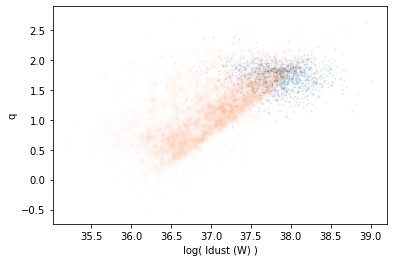

In [49]:
x = np.log10(detected_sample_en1['Ldust_bayes'])
y = detected_sample_en1['q_magphys']
plt.scatter(x,y,s=1,alpha=0.1)

x = np.log10(limit_sample_en1['Ldust_bayes'])
y = limit_sample_en1['q_lim']
plt.scatter(x,y,s=10,alpha=0.01)
plt.xlabel("log( ldust (W) )")
plt.ylabel('q')
plt.show()



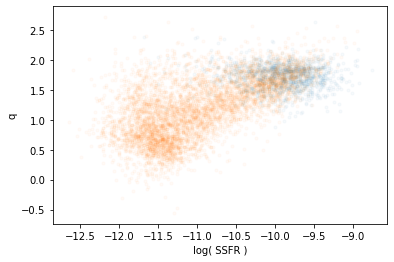

In [50]:
x = np.log10(detected_sample_en1['SFR_bayes']) - detected_sample_en1['Mass_median'] - np.log10(3.8*10**26)
y = detected_sample_en1['q_magphys']
plt.scatter(x,y,s=10,alpha=0.03)

x = np.log10(limit_sample_en1['SFR_bayes']) - limit_sample_en1['Mass_median']
y = limit_sample_en1['q_lim']
plt.scatter(x,y,s=10,alpha=0.03)
plt.xlabel("log( SSFR )")
plt.ylabel('q')
plt.show()

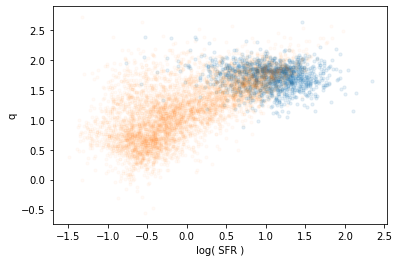

In [51]:
x = np.log10(detected_sample_en1['SFR_bayes']) - np.log10(3.8*10**26)
y = detected_sample_en1['q_magphys']
plt.scatter(x,y,s=10,alpha=0.1)

x = np.log10(limit_sample_en1['SFR_bayes']) 
y = limit_sample_en1['q_lim']
plt.scatter(x,y,s=10,alpha=0.03)
plt.xlabel("log( SFR )")
plt.ylabel('q')
plt.show()

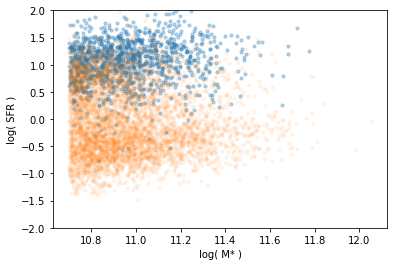

In [59]:
x = detected_sample_en1['Mass_median']
y = np.log10(detected_sample_en1['SFR_bayes']) - np.log10(3.8*10**26)
plt.scatter(x,y,s=10,alpha=0.3)

x = limit_sample_en1['Mass_median']
y = np.log10(limit_sample_en1['SFR_bayes'])
plt.scatter(x,y,s=10,alpha=0.07)
plt.xlabel("log( M* )")
plt.ylabel('log( SFR )')
plt.ylim(-2,2)
plt.show()

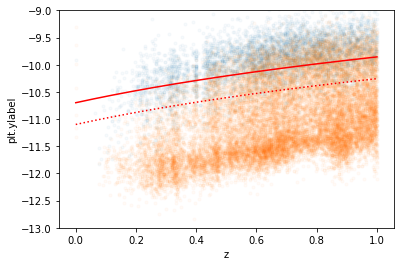

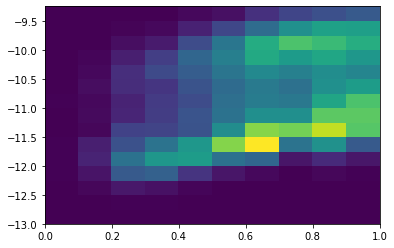

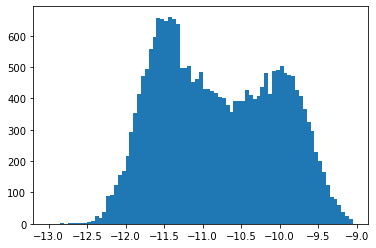

In [565]:
x1 = np.log10(detected_sample_en1['SFR_bayes']) - detected_sample_en1['Mass_median'] - np.log10(3.8*10**26)
y1 = detected_sample_en1['Z_BEST']
plt.scatter(y1,x1,s=10,alpha=0.03)

x2 = np.log10(limit_sample_en1['SFR_bayes']) - limit_sample_en1['Mass_median']
y2 = limit_sample_en1['Z_BEST']
plt.scatter(y2,x2,s=10,alpha=0.03)
plt.xlabel("z")
plt.ylabel('plt.ylabel')

x = np.arange(0,1,0.0001)
y = np.log10(power_law(x,1,2.8)) - np.log10(5E10)
plt.plot(x,y,c='red')

x = np.arange(0,1,0.0001)
y = np.log10(power_law(x,1,2.8)) - np.log10(5E10) - 0.4
plt.plot(x,y,c='red',linestyle='dotted')

plt.ylim(-13,-9)
plt.show()


x = np.append(y1,y2)
y = np.append(x1,x2)
z_bin = np.arange(0,1.1,0.1)
ssfr_bin = np.arange(-13,-9,0.25)
bins = np.meshgrid(z_bin,ssfr_bin)
plt.hist2d(x,y,bins=[z_bin,ssfr_bin])
plt.show()

plt.hist(y,bins=np.arange(-13,-9,0.05))
plt.show()

In [569]:
x1 = np.log10(detected_sample_en1['SFR_bayes']) - detected_sample_en1['Mass_median'] - np.log10(3.8*10**26)
y1 = detected_sample_en1['Z_BEST']

x2 = np.log10(limit_sample_en1['SFR_bayes']) - limit_sample_en1['Mass_median']
y2 = limit_sample_en1['Z_BEST']

x = np.append(y1,y2)
y = np.append(x1,x2)

bins = np.arange(-11,-10,0.1)
z_bins = np.arange(0.1,1.1,0.1)
min_ssfr = []
for n in range(len(z_bins)-1):
    mask_z = (x>z_bins[n]) & (x<z_bins[n+1])
    ssfr = y[mask_z]
    nums,_ = np.histogram(ssfr,bins)
    min_ssfr.append(bins[np.argmin(nums)])

In [570]:
min_ssfr

[-10.400000000000002,
 -10.300000000000002,
 -10.600000000000001,
 -10.8,
 -11.0,
 -10.700000000000001,
 -10.8,
 -10.500000000000002,
 -10.400000000000002]

power law fit parameters: alpha = -0.083527 +\- 0.018152, N = 1.9463 +\- 0.016917
power law fit parameters: alpha = -0.076408 +\- 0.015617, N = 1.936 +\- 0.014571
power law fit parameters: alpha = -0.073768 +\- 0.015487, N = 1.9293 +\- 0.014683
power law fit parameters: alpha = -0.065552 +\- 0.018537, N = 1.9171 +\- 0.017955
power law fit parameters: alpha = -0.068956 +\- 0.019615, N = 1.9179 +\- 0.019287


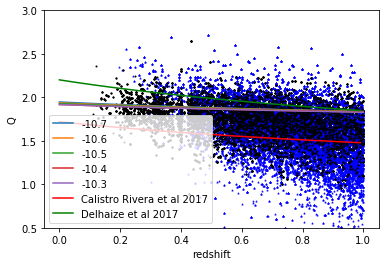

In [599]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'



ssfr_lims = np.arange(-10.7,-10.2,0.1)
for ssfr_lim in ssfr_lims: 
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (lofar_sed_en1['Mass_median']>10.7)# & mask_loc
    agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
    SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26)) > ssfr_lim
    detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]



    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (lofar_magphys_en1['Mass_median']>10.7)# & mask_loc
    SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median']) > ssfr_lim
    limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]


    mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
    detected_data = detected_data[mask]

    mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
    limit_data = limit_data[mask]


    mask_det = det.astype(bool)
    x = limit_data['Z_BEST']
    y = limit_data[lim_name]
    plt.scatter(x,y,s=1,marker='^',c='blue')

    x = detected_data['Z_BEST']
    y = detected_data[det_name]
    plt.scatter(x,y,s=1,c='black',)




    redshifts = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])
    bins_z = []
    percentiles = np.linspace(0,100,11)
    for n,percent in enumerate(percentiles):
        bins_z.append(np.percentile(redshifts,percent))
    bins_z = np.array(bins_z)


    num = 100
    N = int(len(detected_data)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
    N = int(len(limit_data)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

    median_q = []
    kmfs = []
    popts = []
    pcovs = []
    for n in range(num):
        data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
        #data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

        redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
        ldust_det = detected_data[ldust_name][bootstrap_det[n]]

        redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
        ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

        kmf = KaplanMeierFitter() 

        ## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')

        kmfs.append(kmf)


        redshifts = np.append(redshift_det,redshift_lim)



        test = np.digitize(redshifts,bins=bins_z)
        nums_z,counts = np.unique(test,return_counts=True)

        ras_binned = []
        decs_binned = []
        redshift_binned = []
        mean_q_agnfitter = []
        median_q_err = []
        for n,num in enumerate(nums_z[:len(bins_z)-1]):
            mask = (test==num) #& (redshift_all<np.max(redshift))
            q_vals = data[mask]
            q_det = det[mask]
            q_lims = data[mask][~det[mask].astype(bool)]

            redshift_binned.append(redshifts[mask])



            kmf = KaplanMeierFitter()
            kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')

            if n==20:
                bins = np.arange(-3,4,0.1)
                fig,ax1 = plt.subplots()

                ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
                ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

                ax2 = ax1.twinx()
                x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
                y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
                ax2.plot(x,y)
                lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
                upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
                ax2.fill_between(x,lowx,upx,alpha=0.3)
                ax2.set_ylabel('CDF')

                plt.vlines(kmf.median_survival_time_,0,2000)
                plt.ylim(0,1.1)
                plt.xlim(-0.5,3)
                ax1.set_xlabel('q')
                ax1.set_ylabel('N')
                ax1.legend(loc='upper left')
                plt.show()

            x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            x = np.arange(-1,3,0.01)

            lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
            upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

            err = upx-lowx

            mean_q_agnfitter.append(kmf.median_)
            median_q_err.append(err)

        x = get_center(bins_z)
        y = mean_q_agnfitter   
        popt,pcov = curve_fit(power_law,x,y,po,sigma=median_q_err)

        median_q.append(mean_q_agnfitter)
        popts.append(popt)
        pcovs.append([pcov[0,0],pcov[1,1]])

    '''    x = get_center(bins_z)
        y = mean_q_agnfitter[:-1]
        plt.scatter(x,y,c='orange')
        yerr = median_q_err[:-1]
        plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

    median_q = np.array(median_q)
    popts = np.array(popts)
    pcovs = np.array(pcovs)
    medians = np.mean(median_q,axis=0)
    errs = np.std(median_q,axis=0)

    x = get_center(bins_z)
    y = medians
    yerr = errs
    #plt.scatter(x,y,c='orange')
    #plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

    #popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
    x = np.arange(0,1,0.001)
    N_mean = np.mean(popts[:,0])
    N_std = np.std(popts[:,0])
    alpha_mean = np.mean(popts[:,1])
    alpha_std = np.std(popts[:,1])
    y = power_law(x,N_mean,alpha_mean)
    plt.plot(x,y,label=ssfr_lim)

    print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')

    
x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.01)
y = delhaize_fit(x)
plt.plot(x,y,c='green',label='Delhaize et al 2017')
    
plt.ylim(0.5,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

/its/home/im281/.conda/envs/herschelhelp/lib/python3.6/site-packages/lifelines/fitters/kaplan_meier_fitter.py:287: FutureWarning: Please use `median_survival_time_` property instead. Future property `median_` will be removed.
  FutureWarning,


power law fit parameters: alpha = -0.074632 +\- 0.015842, N = 1.9358 +\- 0.014342


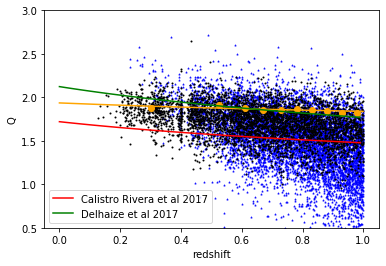

In [612]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'




mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<1.0) & (lofar_sed_en1['Mass_median']>10.7)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
ssfr = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))
SSFR_mask = create_ssfr_mask(lofar_sed_en1['Z_BEST'],ssfr)
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]



mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<1.0) & (lofar_magphys_en1['Mass_median']>10.7)# & mask_loc
ssfr = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median'])
SSFR_mask = create_ssfr_mask(lofar_magphys_en1['Z_BEST'],ssfr)
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]


mask_det = det.astype(bool)
x = limit_data['Z_BEST']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Z_BEST']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black',)




redshifts = np.append(detected_data['Z_BEST'],limit_data['Z_BEST'])
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)


num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = limit_data['Z_BEST'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')

        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = mean_q_agnfitter   
    popt,pcov = curve_fit(power_law,x,y,po,sigma=median_q_err)

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,1,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')

    
x = np.arange(0,1,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

x = np.arange(0,1,0.01)
y = delhaize_fit(x)
plt.plot(x,y,c='green',label='Delhaize et al 2017')
    
plt.ylim(0.5,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

There are 1840 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1692 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
power law fit parameters: alpha = -0.1638 +\- 0.013997, N = 2.0873 +\- 0.0115
There are 1777 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1504 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
power law fit parameters: alpha = -0.16147 +\- 0.014904, N = 2.0798 +\- 0.01267
There are 1692 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1331 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
power law fit parameters: alpha = -0.15968 +\- 0.014357, N = 2.0711 +\- 0.01107
There are 1551 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1133 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
power law fit parameters: alpha = -0.16884 +\- 0.018696, N = 2.0665 +\- 0.01375
There are 1395 gal

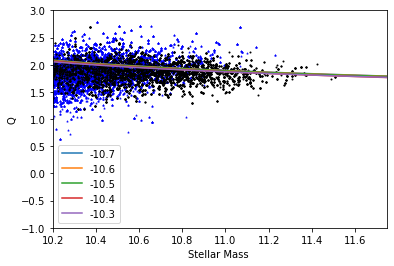

In [597]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7
ssfr_lims = np.arange(-10.7,-10.2,0.1)
for ssfr_lim in ssfr_lims: 
    mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (lofar_sed_en1['Mass_median']>10.2)# & mask_loc
    agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
    SSFR_mask = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26)) > ssfr_lim
    detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
    print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))



    mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (lofar_magphys_en1['Mass_median']>10.2)# & mask_loc
    SSFR_mask = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median']) > ssfr_lim
    limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
    print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


    mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
    detected_data = detected_data[mask]

    mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
    limit_data = limit_data[mask]



    mask_det = det.astype(bool)
    x = limit_data['Mass_median']
    y = limit_data[lim_name]
    plt.scatter(x,y,s=1,marker='^',c='blue')

    x = detected_data['Mass_median']
    y = detected_data[det_name]
    plt.scatter(x,y,s=1,c='black')




    redshifts = np.append(detected_data['Mass_median'],limit_data['Mass_median'])
    bins_z = []
    percentiles = np.linspace(0,100,11).astype(int)
    for n,percent in enumerate(percentiles):
        bins_z.append(np.percentile(redshifts,percent))
    bins_z = np.array(bins_z)
    bins_z[0] = bins_z[0] - 0.001
    bins_z[-1] = bins_z[-1] + 0.001



    num = 100
    N = int(len(detected_data)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
    N = int(len(limit_data)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

    median_q = []
    kmfs = []
    popts = []
    pcovs = []
    for n in range(num):
        data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
        #data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

        redshift_det = detected_data['Mass_median'][bootstrap_det[n]]
        ldust_det = detected_data[ldust_name][bootstrap_det[n]]

        redshift_lim = limit_data['Mass_median'][bootstrap_lim[n]]
        ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

        kmf = KaplanMeierFitter() 

        ## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')

        kmfs.append(kmf)


        redshifts = np.append(redshift_det,redshift_lim)



        test = np.digitize(redshifts,bins=bins_z)
        nums_z,counts = np.unique(test,return_counts=True)

        ras_binned = []
        decs_binned = []
        redshift_binned = []
        mean_q_agnfitter = []
        median_q_err = []
        #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
        #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
        #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
        for n,num in enumerate(nums_z[:len(bins_z)-1]):
            mask = (test==num) #& (redshift_all<np.max(redshift))
            q_vals = data[mask]
            q_det = det[mask]
            q_lims = data[mask][~det[mask].astype(bool)]

            redshift_binned.append(redshifts[mask])



            kmf = KaplanMeierFitter()
            kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')

            if n==20:
                bins = np.arange(-3,4,0.1)
                fig,ax1 = plt.subplots()

                ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
                ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

                ax2 = ax1.twinx()
                x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
                y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
                ax2.plot(x,y)
                lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
                upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
                ax2.fill_between(x,lowx,upx,alpha=0.3)
                ax2.set_ylabel('CDF')

                plt.vlines(kmf.median_survival_time_,0,2000)
                plt.ylim(0,1.1)
                plt.xlim(-0.5,3)
                ax1.set_xlabel('q')
                ax1.set_ylabel('N')
                ax1.legend(loc='upper left')
                plt.show()

            x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            x = np.arange(-1,3,0.01)

            lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
            upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

            err = upx-lowx

            mean_q_agnfitter.append(kmf.median_)
            median_q_err.append(err)

        x = get_center(bins_z)
        y = np.array(mean_q_agnfitter)
        yerr = np.array(median_q_err)
        mask = (~np.isinf(y)) & (~np.isnan(y))
        popt,pcov = curve_fit(power_law,x[mask]-10.2,y[mask],po,sigma=yerr[mask])

        median_q.append(mean_q_agnfitter)
        popts.append(popt)
        pcovs.append([pcov[0,0],pcov[1,1]])

    '''    x = get_center(bins_z)
        y = mean_q_agnfitter[:-1]
        plt.scatter(x,y,c='orange')
        yerr = median_q_err[:-1]
        plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

    median_q = np.array(median_q)
    popts = np.array(popts)
    pcovs = np.array(pcovs)
    medians = np.mean(median_q,axis=0)
    errs = np.std(median_q,axis=0)

    x = get_center(bins_z)
    y = medians
    yerr = errs
    #plt.scatter(x,y,c='orange',label='SF only')
    #plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

    #popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
    x = np.arange(0,2,0.001)
    N_mean = np.mean(popts[:,0])
    N_std = np.std(popts[:,0])
    alpha_mean = np.mean(popts[:,1])
    alpha_std = np.std(popts[:,1])
    y = power_law(x,N_mean,alpha_mean)
    plt.plot(x+10.2,y,label=ssfr_lim)

    print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')







plt.xlim(10.2,11.75)
plt.ylim(0.5,3)
plt.xlabel('Stellar Mass ')
plt.ylabel('Q')
plt.legend()
plt.show()

There are 1624 galaxies detected in the radio with a stellar mass>10.7 and z<1
There are 1343 galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1
power law fit parameters: alpha = -0.15817 +\- 0.017963, N = 2.0665 +\- 0.014097


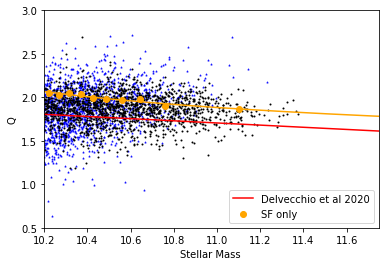

In [610]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<0.4) & (lofar_sed_en1['Mass_median']>10.2)# & mask_loc
agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)
ssfr = (np.log10(lofar_sed_en1['SFR_bayes']) - lofar_sed_en1['Mass_median'] - np.log10(3.8*10**26))
SSFR_mask = create_ssfr_mask(lofar_sed_en1['Z_BEST'],ssfr)
detected_data = lofar_sed_en1[mask_mass_complete_en1 & ~agn_mask & SSFR_mask]
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(len(detected_data)))



mask_mass_complete_limit_en1 = (lofar_magphys_en1['Z_BEST']<0.4) & (lofar_magphys_en1['Mass_median']>10.2)# & mask_loc
ssfr = (np.log10(lofar_magphys_en1['SFR_bayes']) - lofar_magphys_en1['Mass_median'])
SSFR_mask = create_ssfr_mask(lofar_magphys_en1['Z_BEST'],ssfr)
limit_data = lofar_magphys_en1[mask_mass_complete_limit_en1 & SSFR_mask]
print('There are {} galaxies with only a Ldust measurement with a stellar mass>10.7 and z<1'.format(len(limit_data)))


mask = (~np.isnan(detected_data[det_name])) & (~np.isinf(detected_data[det_name]))
detected_data = detected_data[mask]

mask = (~np.isnan(limit_data[lim_name])) & (~np.isinf(limit_data[lim_name]))
limit_data = limit_data[mask]



mask_det = det.astype(bool)
x = limit_data['Mass_median']
y = limit_data[lim_name]
plt.scatter(x,y,s=1,marker='^',c='blue')

x = detected_data['Mass_median']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black')




redshifts = np.append(detected_data['Mass_median'],limit_data['Mass_median'])
bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
bins_z[0] = bins_z[0] - 0.001
bins_z[-1] = bins_z[-1] + 0.001



num = 100
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
N = int(len(limit_data)*0.9)
bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

    redshift_det = detected_data['Mass_median'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]

    redshift_lim = limit_data['Mass_median'][bootstrap_lim[n]]
    ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = np.append(redshift_det,redshift_lim)



    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
    #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
    #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]
        q_lims = data[mask][~det[mask].astype(bool)]

        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')

        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)

    x = get_center(bins_z)
    y = np.array(mean_q_agnfitter)
    yerr = np.array(median_q_err)
    mask = (~np.isinf(y)) & (~np.isnan(y))
    popt,pcov = curve_fit(power_law,x[mask]-10.2,y[mask],po,sigma=yerr[mask])

    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])

'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange',label='SF only')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,2,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x+10.2,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')


x = np.arange(10,12,0.0001)
y = 2.586 - 0.124*(x-10) + np.log10((1400/150)**(-0.78))
plt.plot(x,y,c='red',label='Delvecchio et al 2020')




plt.xlim(10.2,11.75)
plt.ylim(0.5,3)
plt.xlabel('Stellar Mass ')
plt.ylabel('Q')
plt.legend()
plt.show()

In [608]:
np.log10((1400/150)**(-0.7))

-0.6790257436357897

From this plot i place a cut in SFR>1 to ensure my sample only has SF galaxies

## Compare with Calistro Rivera et al 2017

In [422]:
#create a mask to select a sample that is complete in stellar mass and redshift
#for a mass complete sample at z<1.0 Mstar>10.7

agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)

mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<4.0) & (lofar_sed_en1['Peak_flux']>0.0006) & (~agn_mask)
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_en1)))
detected_sample_en1_calistro = lofar_sed_en1[mask_mass_complete_en1]


There are 1066 galaxies detected in the radio with a stellar mass>10.7 and z<1


measured median from the detections is: 1.6788408925509088
measured median using survival analysis is: 1.6788408925509088


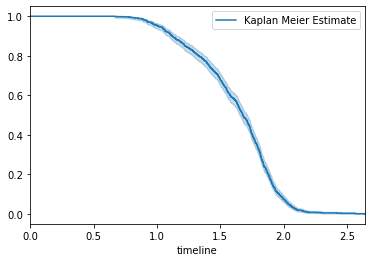

median q = 1.6788408925509088


In [423]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'


detected_data = detected_sample_en1_calistro[det_name]
mask = (~np.isnan(detected_sample_en1_calistro[det_name])) & (~np.isinf(detected_sample_en1_calistro[det_name]))
detected_data = detected_data[mask]
redshift_det = detected_sample_en1_calistro['Z_BEST'][mask]
ldust_det = detected_sample_en1_calistro[ldust_name][mask]



data = detected_data
#data[flag_detected] = q_lim[flag_detected]
det = np.ones(len(detected_data))
print('measured median from the detections is: {}'.format(np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(kmf.median_survival_time_))
kmf.plot()
plt.show()

print('median q = {}'.format(kmf.median_survival_time_))





In [457]:
bins_z = np.arange(0,4.0,0.5)


redshifts = redshift_det

bins_z = []
percentiles = np.linspace(0,100,11).astype(int)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


test = np.digitize(redshifts,bins=bins_z)
nums_z,counts = np.unique(test,return_counts=True)

ras_binned = []
decs_binned = []
redshift_binned = []
mean_q_agnfitter = []
errs = []
for n,num in enumerate(nums_z[:len(bins_z)-1]):
    mask = (test==num) #& (redshift_all<np.max(redshift))
    q_vals = data[mask]
    q_det = det[mask]
    
    redshift_binned.append(redshifts[mask])
    
    ''' bins = np.arange(-3,5,0.1)
    plt.hist(q_vals[det[mask].astype(bool)],log=True,label='detections',bins=bins,histtype='step')
    plt.title('{}'.format(bins_z[n]))
    plt.legend()
    plt.show()'''
    
    '''plt.hist(redshifts[mask],bins=np.arange(0,5,0.25),log=True,histtype='step')
    plt.xlabel('redshift')
    plt.title('{}'.format(bins_z[n]))
    plt.show()'''
    
    
    kmf = KaplanMeierFitter()
    kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
    print('measured median using survival analysis is: {}'.format(kmf.median_))
    
    mean_q_agnfitter.append(kmf.median_)
    
    x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
    x = np.arange(-1,3,0.01)

    lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
    lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
    upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
    upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

    err = upx-lowx
    errs.append(err)

[0.0094     0.11893264 0.20094    0.25232    0.31317248 0.44
 0.61196    0.8304     1.18648    1.8469     3.7359    ]
measured median using survival analysis is: 1.9338732616158048
measured median using survival analysis is: 1.885243671993905
measured median using survival analysis is: 1.815369514492847
measured median using survival analysis is: 1.795371127592297
measured median using survival analysis is: 1.7464253530695437
measured median using survival analysis is: 1.664138492033505
measured median using survival analysis is: 1.5507981159501192
measured median using survival analysis is: 1.39423308214052
measured median using survival analysis is: 1.3209566212405655
measured median using survival analysis is: 1.2005317976717969


[ 1.9809878  -0.42183349] [[ 0.00063283 -0.00049558]
 [-0.00049558  0.00064384]]


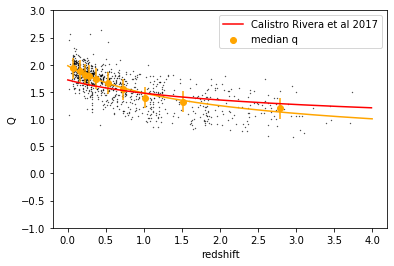

In [458]:
mask_det = det.astype(bool)
x = redshifts[~mask_det]
y = data[~mask_det]
plt.scatter(x,y,s=0.1,marker='^',c='blue')

x = redshifts[mask_det]
y = data[mask_det]
plt.scatter(x,y,s=0.1,c='black')

x = get_center(bins_z)
y = mean_q_agnfitter
plt.scatter(x,y,label='median q',c='orange')
plt.errorbar(x,y,yerr=errs,linestyle='',color='orange')
 
popt,pcov = curve_fit(power_law,x,y,sigma=errs)
print(popt,pcov)
x = np.arange(0,4,0.001)
y = power_law(x,popt[0],popt[1])
plt.plot(x,y,c='orange')

x = np.arange(0,4,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

There are 1066 galaxies detected in the radio with a stellar mass>10.7 and z<1
[0.0094    0.1190408 0.2036    0.2543    0.3186    0.4575    0.6347
 0.87505   1.2333    1.956     3.9357   ]
power law fit parameters: alpha = -0.32174 +\- 0.025948, N = 1.8587 +\- 0.022137


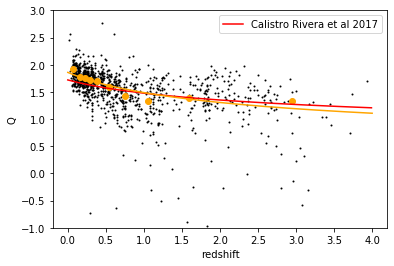

In [465]:
#Now look at redshift evolution scatter with bootstraping
#Bootstrap the sample and find the median q to see the variation you get 

det_name = 'q_agnfitter'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

agn_mask = lofar_sed_en1['AGN_final'].astype(bool) | lofar_sed_en1['RadioAGN_final'].astype(bool)

mask_mass_complete_en1 = (lofar_sed_en1['Z_BEST']<4.0) & (lofar_sed_en1['Peak_flux']>0.0006) & (~agn_mask)
print('There are {} galaxies detected in the radio with a stellar mass>10.7 and z<1'.format(np.sum(mask_mass_complete_en1)))
detected_sample_en1_calistro = lofar_sed_en1[mask_mass_complete_en1]



detected_data = detected_sample_en1_calistro
mask = (~np.isnan(detected_sample_en1_calistro[det_name])) & (~np.isinf(detected_sample_en1_calistro[det_name]))
detected_data = detected_data[mask]





x = detected_data['Z_BEST']
y = detected_data[det_name]
plt.scatter(x,y,s=1,c='black',)

x = np.arange(0,4,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')


redshifts = detected_data['Z_BEST']
bins_z = []
percentiles = np.linspace(0,100,11)
for n,percent in enumerate(percentiles):
    bins_z.append(np.percentile(redshifts,percent))
bins_z = np.array(bins_z)
print(bins_z)


num = 10
N = int(len(detected_data)*0.9)
bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)


median_q = []
kmfs = []
popts = []
pcovs = []
for n in range(num):
    data = detected_data[bootstrap_det[n]][det_name]
    #data[flag_detected] = q_lim[flag_detected]
    det = np.ones(len(bootstrap_det[n]))
    
    redshift_det = detected_data['Z_BEST'][bootstrap_det[n]]
    ldust_det = detected_data[ldust_name][bootstrap_det[n]]
    

    kmf = KaplanMeierFitter() 

    ## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    kmfs.append(kmf)


    redshifts = redshift_det
    


    test = np.digitize(redshifts,bins=bins_z)
    nums_z,counts = np.unique(test,return_counts=True)

    ras_binned = []
    decs_binned = []
    redshift_binned = []
    mean_q_agnfitter = []
    median_q_err = []
    for n,num in enumerate(nums_z[:len(bins_z)-1]):
        mask = (test==num) #& (redshift_all<np.max(redshift))
        q_vals = data[mask]
        q_det = det[mask]


        redshift_binned.append(redshifts[mask])



        kmf = KaplanMeierFitter()
        kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')
        
        if n==20:
            bins = np.arange(-3,4,0.1)
            fig,ax1 = plt.subplots()

            ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
            ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

            ax2 = ax1.twinx()
            x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
            ax2.plot(x,y)
            lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            ax2.fill_between(x,lowx,upx,alpha=0.3)
            ax2.set_ylabel('CDF')

            plt.vlines(kmf.median_survival_time_,0,2000)
            plt.ylim(0,1.1)
            plt.xlim(-0.5,3)
            ax1.set_xlabel('q')
            ax1.set_ylabel('N')
            ax1.legend(loc='upper left')
            plt.show()

        x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
        x = np.arange(-1,3,0.01)

        lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
        lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
        upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
        upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

        err = upx-lowx

        mean_q_agnfitter.append(kmf.median_)
        median_q_err.append(err)
        
    x = get_center(bins_z)
    y = mean_q_agnfitter   
    popt,pcov = curve_fit(power_law,x,y,po,sigma=median_q_err)
    
    median_q.append(mean_q_agnfitter)
    popts.append(popt)
    pcovs.append([pcov[0,0],pcov[1,1]])
    
'''    x = get_center(bins_z)
    y = mean_q_agnfitter[:-1]
    plt.scatter(x,y,c='orange')
    yerr = median_q_err[:-1]
    plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')'''

median_q = np.array(median_q)
popts = np.array(popts)
pcovs = np.array(pcovs)
medians = np.mean(median_q,axis=0)
errs = np.std(median_q,axis=0)

x = get_center(bins_z)
y = medians
yerr = errs
plt.scatter(x,y,c='orange')
plt.errorbar(x,y,yerr=yerr,c='orange',linestyle='')

#popt,pcov = curve_fit(power_law,x,y,po,sigma=yerr)
x = np.arange(0,4,0.001)
N_mean = np.mean(popts[:,0])
N_std = np.std(popts[:,0])
alpha_mean = np.mean(popts[:,1])
alpha_std = np.std(popts[:,1])
y = power_law(x,N_mean,alpha_mean)
plt.plot(x,y,c='orange')

print(f'power law fit parameters: alpha = {alpha_mean:2.5} +\- {alpha_std:2.5}, N = {N_mean:2.5} +\- {N_std:2.5}')
    
plt.ylim(-1,3)
plt.xlabel('redshift')
plt.ylabel('Q')
plt.legend()
plt.show()

In [ ]:
q_mask = lofar_sed_en1['q_magphys']<-0.5
lofar_sed_en1[q_mask]

## Compare with Lingyu's results

In [ ]:
lingyu_ir_results = Table.read('../../lofar/deep_fields/ELAIS-N1/data/IR_lum_sources_lingyu/lingyu_en1/multi_en1_18_final_overlap.fits', character_as_bytes=False)
lingyu_ir_results[0]
lingyu_join = join(lingyu_ir_results,lofar_sed_en1,keys='Source_Name',table_names=['XID','lingyu'])
print(len(lingyu_join))
lingyu_join[0]

In [ ]:
np.sum(lingyu_join['radio_AGN'].astype(bool) & np.sum(lingyu_join['optical_AGN'].astype(bool)))

In [ ]:
x = lingyu_join['Z_BEST_XID']
y = lingyu_join['q_fritz']
mask = (~np.isnan(x)) & (~np.isinf(x)) & (~np.isnan(y)) & (~np.isinf(y))
x = x[mask]
y = y[mask]
plt.scatter(x,y,c='black',s=0.1)

bins = np.arange(0,6,0.2)
medians,_,_ = binned_statistic(x,y,'median',bins=bins)
centers = get_center(bins)
plt.scatter(centers,medians,c='orange',label='lingyu_medians')

x = bins_z[nums_z-1]
y = mean_q_agnfitter
plt.scatter(x,y,c='green',label='my medians')

x = np.arange(0,6,0.01)
y = calistro_fit(x)
plt.plot(x,y,c='red',label='Calistro Rivera et al 2017')

plt.xlim(0,1)
plt.legend()
plt.xlabel('z')
plt.ylabel('q')
plt.show()


x = np.log10(detected_sample_en1['radio_luminosity'])
y = np.log10(detected_sample_en1['bayes.dust.luminosity_fritz'])
plt.scatter(x,y,c='black',s=1)

x = np.log10(lingyu_join['radio_luminosity'])
y = np.log10(lingyu_join['bayes.dust.luminosity_fritz'])
plt.scatter(x,y,c='orange',s=1)
plt.show()

#### x = np.log10(detected_sample_en1['radio_luminosity'])
y = np.log10(detected_sample_en1['bayes.dust.luminosity_fritz'])
binsx = np.arange(21,27,0.25)
binsy = np.arange(35,40,0.25)
image,_,_ = np.histogram2d(x,y,bins=[binsx,binsy])
plt.contour(image,colors='black',label='lofar')
#plt.scatter(x,y,c='black',s=1)

x = np.log10(lingyu_join['radio_luminosity'])
y = np.log10(lingyu_join['bayes.dust.luminosity_fritz'])
binsx = np.arange(21,27,0.25)
binsy = np.arange(35,40,0.25)
image,_,_ = np.histogram2d(x,y,bins=[binsx,binsy])
plt.contour(image,colors='red',label='lingyu')
#plt.scatter(x,y,c='orange',s=1)
plt.legend()
plt.show()

In [ ]:
bins=np.arange(-1,3,0.1)
y = lingyu_join['q_fritz']
plt.hist(y,bins=bins,log=True,histtype='step',label='lingyu')

y = detected_sample_en1['q_fritz']
plt.hist(y,bins=bins,log=True,histtype='step',label='lofar')
plt.legend()
plt.show()

In [ ]:
np.median(y)

## Measure FIRC for different LIR selections

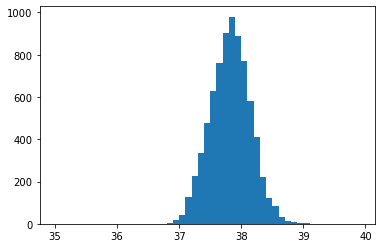

In [27]:
y = np.log10(detected_sample_en1['Ldust_bayes'])
bins = np.arange(35,40,0.1)
plt.hist(y,bins=bins)
plt.show()

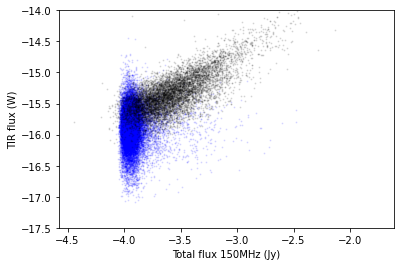

In [48]:
dist = cosmo.luminosity_distance(limit_sample_en1['Z_BEST']).to(u.m).value
lir_flux = limit_sample_en1['Ldust_bayes']/(4*np.pi*dist*dist)
col_lir_flux = Column(name='TIR_flux',data=lir_flux)
limit_sample_en1.add_column(col_lir_flux)

x = np.log10(limit_sample_en1['radio_flux_limit'])
y = np.log10(lir_flux)
plt.scatter(x,y,alpha=0.1,s=1,c='blue')

dist = cosmo.luminosity_distance(detected_sample_en1['Z_BEST']).to(u.m).value
lir_flux = detected_sample_en1['Ldust_bayes']/(4*np.pi*dist*dist)
col_lir_flux = Column(name='TIR_flux',data=lir_flux)
detected_sample_en1.add_column(col_lir_flux)

x = np.log10(detected_sample_en1['Total_flux'])
y = np.log10(lir_flux)
plt.scatter(x,y,alpha=0.1,s=1,c='black')

plt.xlabel('Total flux 150MHz (Jy)')
plt.ylabel('TIR flux (W)')
plt.ylim(-17.5,-14)
plt.show()

measured median from the detections is: 1.8233543589695813
measured median using survival analysis is: 1.8341526583123873


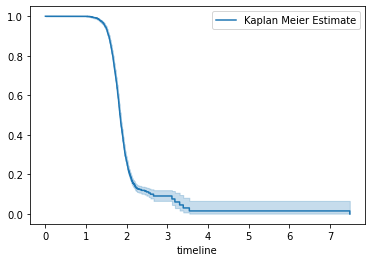

median q = 1.8341526583123873


In [30]:
mask_det_lir = detected_sample_en1['Ldust_bayes']>1E38
mask_lim_lir = limit_sample_en1['Ldust_bayes']>1E38
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'


detected_data = detected_sample_en1[det_name]
mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name])) & (mask_det_lir)
detected_data = detected_data[mask]
redshift_det = detected_sample_en1['Z_BEST'][mask]
ldust_det = detected_sample_en1[ldust_name][mask]

limit_data = limit_sample_en1[lim_name]
mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name])) & (mask_lim_lir)
limit_data = limit_data[mask]
redshift_lim = limit_sample_en1['Z_BEST'][mask]
ldust_lim = limit_sample_en1[ldust_name][mask]

data = np.append(detected_data,limit_data)
#data[flag_detected] = q_lim[flag_detected]
det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
print('measured median from the detections is: {}'.format(np.median(data)))

kmf = KaplanMeierFitter() 

## Fit the data into the model
kmf.fit(data, det,label='Kaplan Meier Estimate')

## Create an estimate
print('measured median using survival analysis is: {}'.format(kmf.median_survival_time_))
kmf.plot()
plt.show()

print('median q = {}'.format(kmf.median_survival_time_))




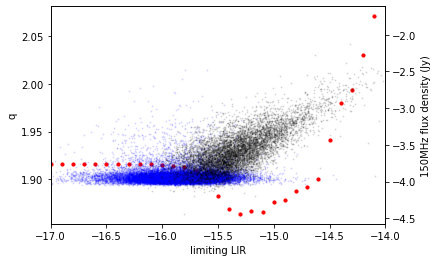

In [60]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

lir_bins = np.arange(-17,-14,0.1)
median_q_lir_no_agn = []
for n,lir_lim in enumerate(lir_bins):
    mask_det_lir = (np.log10(detected_sample_en1['TIR_flux'])>lir_lim) & (~agn_mask)
    mask_lim_lir = (np.log10(limit_sample_en1['TIR_flux'])>lir_lim)


    detected_data = detected_sample_en1[det_name]
    mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name])) & (mask_det_lir)
    detected_data = detected_data[mask]
    redshift_det = detected_sample_en1['Z_BEST'][mask]
    ldust_det = detected_sample_en1[ldust_name][mask]

    limit_data = limit_sample_en1[lim_name]
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name])) & (mask_lim_lir)
    limit_data = limit_data[mask]
    redshift_lim = limit_sample_en1['Z_BEST'][mask]
    ldust_lim = limit_sample_en1[ldust_name][mask]

    data = np.append(detected_data,limit_data)
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
    #print('measured median from the detections is: {}'.format(np.median(data)))

    kmf = KaplanMeierFitter() 

## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    #print('median q = {}'.format(kmf.median_))

    median_q_lir_no_agn.append(kmf.median_survival_time_)
    
lir_bins = np.arange(-17,-14,0.1)
median_q_lir = []
for n,lir_lim in enumerate(lir_bins):
    mask_det_lir = (np.log10(detected_sample_en1['TIR_flux'])>lir_lim)
    mask_lim_lir = (np.log10(limit_sample_en1['TIR_flux'])>lir_lim)


    detected_data = detected_sample_en1[det_name]
    mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name])) & (mask_det_lir)
    detected_data = detected_data[mask]
    redshift_det = detected_sample_en1['Z_BEST'][mask]
    ldust_det = detected_sample_en1[ldust_name][mask]

    limit_data = limit_sample_en1[lim_name]
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name])) & (mask_lim_lir)
    limit_data = limit_data[mask]
    redshift_lim = limit_sample_en1['Z_BEST'][mask]
    ldust_lim = limit_sample_en1[ldust_name][mask]

    data = np.append(detected_data,limit_data)
    #data[flag_detected] = q_lim[flag_detected]
    det = np.append(np.ones(len(detected_data)),np.zeros(len(limit_data)))
    #print('measured median from the detections is: {}'.format(np.median(data)))

    kmf = KaplanMeierFitter() 

## Fit the data into the model
    kmf.fit(data, det,label='Kaplan Meier Estimate')

    #print('median q = {}'.format(kmf.median_))

    median_q_lir.append(kmf.median_survival_time_)

fig,ax1 = plt.subplots()
x = lir_bins
y = median_q_lir_no_agn
#ax1.scatter(x,y,label='removed agn',c='blue',s=10)
x = lir_bins
y = median_q_lir
ax1.scatter(x,y,label='included agn',c='red',s=10)
ax1.set_xlabel('limiting LIR')
ax1.set_ylabel('q')

ax2 = ax1.twinx()

y = np.log10(limit_sample_en1['radio_flux_limit'])
x = np.log10(limit_sample_en1['TIR_flux'])
ax2.scatter(x,y,alpha=0.1,s=1,c='blue') 

y = np.log10(detected_sample_en1['Total_flux'])
x = np.log10(detected_sample_en1['TIR_flux'])
ax2.scatter(x,y,alpha=0.1,s=1,c='black') 

ax2.set_ylabel('150MHz flux density (Jy)')

plt.xlim(-17,-14)

plt.show()

[10.44900715 10.49177275 10.53714137 10.58377512 10.63427965 10.68928601
 10.74912678 10.81901728 10.90514475 11.02437111 11.60457696]
[10.44900715 10.49188201 10.53738537 10.58389638 10.63461479 10.68961977
 10.74958054 10.81928113 10.90543869 11.02442556 11.60457696]
[10.44900715 10.49196527 10.53755166 10.58420977 10.63509636 10.69017951
 10.74994235 10.81969366 10.90576129 11.0249337  11.60457696]
[10.44900715 10.49220651 10.53808863 10.58469618 10.63600537 10.69107137
 10.75059162 10.82032494 10.90607205 11.02533778 11.60457696]
[10.44900715 10.49248657 10.53850932 10.58535518 10.63681681 10.69242595
 10.75182468 10.82133102 10.90657346 11.02642027 11.60457696]
[10.44900715 10.49325304 10.54007803 10.587315   10.63884981 10.69464208
 10.75407426 10.82340432 10.90884559 11.02850371 11.60457696]
[10.44900715 10.49380597 10.54156356 10.58929657 10.6413812  10.69784042
 10.75703339 10.82648868 10.91126514 11.03142235 11.60457696]
[10.44900715 10.49460286 10.54358575 10.59193414 10.644

ValueError: x and y must be the same size

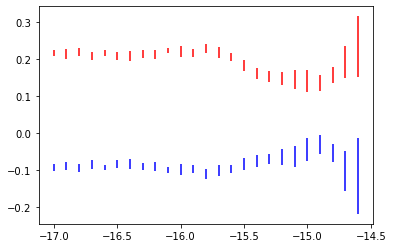

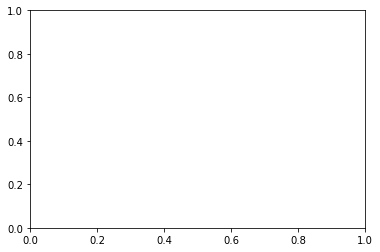

In [70]:
det_name = 'q_magphys'
lim_name = 'q_lim'
ldust_name = 'Ldust_bayes'

agn_mask = detected_sample_en1['AGN_final'].astype(bool) | detected_sample_en1['RadioAGN_final'].astype(bool)

lir_bins = np.arange(-17,-14.5,0.1)
median_q_lir_no_agn = []
m_err = []
c_err = []
m_diff = []
c_diff = []
for n,lir_lim in enumerate(lir_bins):
    mask_det_lir = (np.log10(detected_sample_en1['TIR_flux'])>lir_lim) & (~agn_mask)
    mask_lim_lir = (np.log10(limit_sample_en1['TIR_flux'])>lir_lim)


    detected_data = detected_sample_en1
    mask = (~np.isnan(detected_sample_en1[det_name])) & (~np.isinf(detected_sample_en1[det_name])) & (mask_det_lir)
    detected_data = detected_data[mask]
    redshift_det = detected_sample_en1['Z_BEST'][mask]
    ldust_det = detected_sample_en1[ldust_name][mask]

    limit_data = limit_sample_en1
    mask = (~np.isnan(limit_sample_en1[lim_name])) & (~np.isinf(limit_sample_en1[lim_name])) & (mask_lim_lir)
    limit_data = limit_data[mask]
    redshift_lim = limit_sample_en1['Z_BEST'][mask]
    ldust_lim = limit_sample_en1[ldust_name][mask]


    
    
    redshifts = np.append(np.log10(detected_data['Mstar_bayes']/3.8E26),np.log10(limit_data['Mstar_bayes']/3.8E26))
    bins_z = []
    percentiles = np.linspace(0,100,11).astype(int)
    for n,percent in enumerate(percentiles):
        bins_z.append(np.percentile(redshifts,percent))
    bins_z = np.array(bins_z)
    bins_z[0] = bins_z[0] - 0.001
    bins_z[-1] = bins_z[-1] + 0.001



    num = 10
    N = int(len(detected_data)*0.9)
    bootstrap_det = bootstrap(np.arange(0,len(detected_data),1),num,samples=N).astype(int)
    N = int(len(limit_data)*0.9)
    bootstrap_lim = bootstrap(np.arange(0,len(limit_data),1),num,samples=N).astype(int)

    median_q = []
    kmfs = []
    popts = []
    pcovs = []
    for n in range(num):
        data = np.append(detected_data[bootstrap_det[n]][det_name],limit_data[bootstrap_lim[n]][lim_name])
        #data[flag_detected] = q_lim[flag_detected]
        det = np.append(np.ones(len(bootstrap_det[n])),np.zeros(len(bootstrap_lim[n])))

        redshift_det = np.log10(detected_data['Mstar_bayes']/3.8E26)[bootstrap_det[n]]
        ldust_det = detected_data[ldust_name][bootstrap_det[n]]

        redshift_lim = np.log10(limit_data['Mstar_bayes']/3.8E26)[bootstrap_lim[n]]
        ldust_lim = limit_data[ldust_name][bootstrap_lim[n]]

        kmf = KaplanMeierFitter() 

        ## Fit the data into the model
        kmf.fit(data, det,label='Kaplan Meier Estimate')

        kmfs.append(kmf)


        redshifts = np.append(redshift_det,redshift_lim)



        test = np.digitize(redshifts,bins=bins_z)
        nums_z,counts = np.unique(test,return_counts=True)

        ras_binned = []
        decs_binned = []
        redshift_binned = []
        mean_q_agnfitter = []
        median_q_err = []
        #there is an error is a source has a stellar mass equal to the right hand side of the final mass bin
        #if this happens then they are put into their own seperate bin so you end up with more nums than there are bins
        #This causes an error when it comes to plotting them. To solve this i only look at the first ten bins
        for n,num in enumerate(nums_z[:len(bins_z)-1]):
            mask = (test==num) #& (redshift_all<np.max(redshift))
            q_vals = data[mask]
            q_det = det[mask]
            q_lims = data[mask][~det[mask].astype(bool)]

            redshift_binned.append(redshifts[mask])



            kmf = KaplanMeierFitter()
            kmf.fit(q_vals, q_det,label='Kaplan Meier Estimate')

            if n==20:
                bins = np.arange(-3,4,0.1)
                fig,ax1 = plt.subplots()

                ax1.hist(q_vals[q_det.astype(bool)],label='detections',bins=bins,histtype='step',color='black')
                ax1.hist(q_vals[~q_det.astype(bool)],label='lower limit',bins=bins,histtype='step',color='blue')

                ax2 = ax1.twinx()
                x = kmf.cumulative_density_['Kaplan Meier Estimate'].index
                y = kmf.cumulative_density_['Kaplan Meier Estimate'].values
                ax2.plot(x,y)
                lowx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
                upx = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
                ax2.fill_between(x,lowx,upx,alpha=0.3)
                ax2.set_ylabel('CDF')

                plt.vlines(kmf.median_survival_time_,0,2000)
                plt.ylim(0,1.1)
                plt.xlim(-0.5,3)
                ax1.set_xlabel('q')
                ax1.set_ylabel('N')
                ax1.legend(loc='upper left')
                plt.show()

            x_kmf = kmf.cumulative_density_['Kaplan Meier Estimate'].index
            x = np.arange(-1,3,0.01)

            lowx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_lower_0.95']
            lowx = np.interp(kmf.median_survival_time_,x_kmf,lowx_kmf)
            upx_kmf = kmf.confidence_interval_cumulative_density_['Kaplan Meier Estimate_upper_0.95']
            upx = np.interp(kmf.median_survival_time_,x_kmf,upx_kmf)

            err = upx-lowx

            mean_q_agnfitter.append(kmf.median_survival_time_)
            median_q_err.append(err)

        x = get_center(bins_z)
        y = np.array(mean_q_agnfitter)
        yerr = np.array(median_q_err)
        mask = (~np.isinf(y)) & (~np.isnan(y))
        popt,pcov = curve_fit(linear_fit,x[mask]-10.0,y[mask],sigma=yerr[mask])

        median_q.append(mean_q_agnfitter)
        popts.append(popt)
        pcovs.append([pcov[0,0],pcov[1,1]])
        
    median_q = np.array(median_q)
    popts = np.array(popts)
    pcovs = np.array(pcovs)
    medians = np.mean(median_q,axis=0)
    errs = np.std(median_q,axis=0)
    
    m_mean = np.mean(popts[:,0])
    m_std = np.std(popts[:,0])
    c_mean = np.mean(popts[:,1])
    c_std = np.std(popts[:,1])
    
    m_err.append(m_std)
    c_err.append(c_std)
    
    m_diff.append(m_mean + 0.124)
    c_diff.append(c_mean - (2.586 + np.log10((1400/150)**(-0.73))))
    


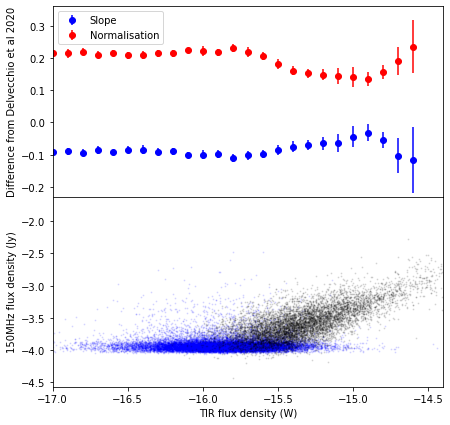

In [85]:
fig,axs = plt.subplots(2,1,sharex=True, gridspec_kw={'hspace': 0},figsize=[7,7])
axs[0].errorbar(lir_bins,m_diff,yerr=m_err,linestyle='',c='blue',marker='o',label='Slope')
axs[0].errorbar(lir_bins,c_diff,yerr=c_err,linestyle='',c='red',marker='o',label='Normalisation')
    
axs[0].set_ylabel('Difference from Delvecchio et al 2020')
axs[0].legend(loc='upper left')
axs[0].set_ylim(-0.23,0.36)



y = np.log10(limit_sample_en1['radio_flux_limit'])
x = np.log10(limit_sample_en1['TIR_flux'])
axs[1].scatter(x,y,alpha=0.1,s=1,c='blue') 

y = np.log10(detected_sample_en1['Total_flux'])
x = np.log10(detected_sample_en1['TIR_flux'])
axs[1].scatter(x,y,alpha=0.1,s=1,c='black') 

axs[1].set_ylabel('150MHz flux density (Jy)')
axs[1].set_xlabel('TIR flux density (W)')

plt.xlim(-17,-14.4)

plt.show()

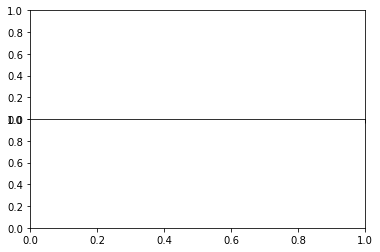

In [74]:
fig,axs = plt.subplots(2,1,sharex=True, gridspec_kw={'hspace': 0})